In [1]:
'''
Author:		Hrag Najarian
Date:		April 2025
Purpose:	Act as a worksheet to analyze data from Chapter 2 of my dissertation.
'''


'\nAuthor:\t\tHrag Najarian\nDate:\t\tApril 2025\nPurpose:\tAct as a worksheet to analyze data from Chapter 2 of my dissertation.\n'

In [1]:
from wrf import getvar, ALL_TIMES, default_fill
import matplotlib as mpl
import cartopy.crs as ccrs
import glob
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import numpy as np
import xarray as xr
from flox.xarray import xarray_reduce
from flox import Aggregation
import os
import pandas as pd
import time
from math import cos, asin, sqrt, pi, atan, degrees, tan
import scipy
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Function List

In [2]:
def wind_direction(u, v):
    """
    Calculate wind direction from zonal and meridional wind components.
    
    Parameters:
    u (float or array-like): Zonal wind component (positive for eastward, negative for westward).
    v (float or array-like): Meridional wind component (positive for northward, negative for southward).
    
    Returns:
    float or ndarray: Wind direction in degrees (meteorological convention).
    """
	# Calculate wind direction in mathematical convention (counterclockwise from positive x-axis)
    # math_direction = np.degrees(np.arctan2(v, u))  # Convert radians to degrees

    # Convert to meteorological convention (clockwise from true north)
    direction = (180 + np.degrees(np.arctan2(-u, -v))) % 360
    return direction

In [3]:
# Assumes cartesian coordinate system
def calculate_angle_between_points(p1, p2):
    # Calculate differences
    dy = p2[0] - p1[0]  # Lats
    dx = p2[1] - p1[1]  # Lons
    # Find the angle (radians)
    theta = math.atan(dy/dx)
    
    return theta

# # Example points
# point1 = [0, 0]
# point2 = [1, 1]

# theta = math.degrees(calculate_angle_between_points(point1, point2))
# print(f"The angle between the points is {theta} degrees")

In [4]:
def vertical_integration(da):
	# Do a rolling mean to get the average between two pressure levels
	da = da.rolling(bottom_top=2).mean()
	# Create dp and make it the same shape as da.
	dp_levels = da.bottom_top.diff(dim='bottom_top').expand_dims(dim={'Time':len(da.Time),'Distance':len(da.Distance),'Spread':len(da.Spread)})
	# Now remove the first level of da since it's nan's
	da = da.isel(bottom_top=slice(1,None))

	da_vertically_integrated = (da * dp_levels).sum('bottom_top') / (-9.8)

	return da_vertically_integrated

In [5]:
def round_to_two_significant_figures(number):
    """
    Rounds a float value to two significant figures using np.ceil or np.floor.

    Args:
        number (float): The input float value.

    Returns:
        float: The rounded value.
    """
    # Calculate the order of magnitude (power of 10) for the input number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))

    # Calculate the factor to round to two significant figures
    factor = 10**(2 - order_of_magnitude)

    # Round the number using np.ceil or np.floor
    rounded_value = np.ceil(number * factor) / factor

    return rounded_value

def round_to_one_significant_figures(number):
    """
    Rounds a float value to two significant figures using np.ceil or np.floor.

    Args:
        number (float): The input float value.

    Returns:
        float: The rounded value.
    """
    # Calculate the order of magnitude (power of 10) for the input number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))

    # Calculate the factor to round to two significant figures
    factor = 10**(1 - order_of_magnitude)

    # Round the number using np.ceil or np.floor
    rounded_value = np.ceil(number * factor) / factor

    return rounded_value

round_to_one_significant_figures(0.00001427)

1.5e-05

In [6]:
# Linear Regression Function based on the scipy.stats.linregress function

# Make sure the x and y values are 1-D matrices

# Inclusion of custom start and end lag inputs. 
	# If you don't care for the negative lags, then start at 0, or vise versa.
	# This way you're not wasting resources on lags you don't need.

def linreg(x, y, min_lag, max_lag):
	# Initialize matrices
	slopes = []
	yintercepts = []
	rvalues = []
	pvalues = []
	stderrors = []
	# How to disypher what lag relationships mean:
		# Negative lag implies that x at the moment correlates with your y in the future
		# Positive lag implies that x at the moment correlates with you y in the past
	for lag in range(min_lag,max_lag+1):	# itterate from min_lag to max_lag (+1 because of range function)
		if lag == 0:	
			slope, yintercept, rvalue, pvalue, stderror = scipy.stats.linregress(x, y)
		elif lag < 0:
			slope, yintercept, rvalue, pvalue, stderror = scipy.stats.linregress(x[:lag], y[-lag:])
		elif lag > 0:
			slope, yintercept, rvalue, pvalue, stderror = scipy.stats.linregress(x[lag:], y[:-lag])
		
		# Append the values!
		slopes.append(slope)
		yintercepts.append(yintercept)
		rvalues.append(rvalue)
		pvalues.append(pvalue)
		stderrors.append(stderror)

	# Compile data into a dataarray for easy management
	da_reg = xr.DataArray(
		data=np.arange(min_lag,max_lag+1),
		dims='lag',
		coords=dict(
			slope = ('lag', slopes),
			yintercept = ('lag', yintercepts),
			rvalue = ('lag', rvalues),
			pvalue = ('lag', pvalues),
			stderror= ('lag',stderrors)
			),
		name='lin_reg'
		)

	return da_reg

In [7]:
# Calculate Temperature [K] via potential temperature equation [PT = T * (Po/P) ^ .286]
	# Link: https://glossary.ametsoc.org/wiki/Potential_temperature 
def theta_to_temp(theta):
	# PT = T * (P0/P)^(R/Cp)
		# PT = Potential temperature/theta
		# T = Temperature
		# P0 = 1000 hPa
		# P = Pressure
		# R = Gas constant for air (287.052874 J/(kg*K))
		# Cp = Specific heat capacity at constant pressure (1003.5 J/(kg*K))
			# R/Cp = 0.286
	# so
	# T = PT / (P0/P)^(0.286)
	temp = xr.zeros_like(theta)
	P = theta.bottom_top.values
	for i in range(len(P)):
		temp[:,i,...] = theta[:,i,...] / (1000/P[i])**(0.286)
	
	temp.name = 'Temperature'
	temp = temp.assign_attrs(Units='K')
	
	return temp

In [8]:
# Calculate Potential Temperature [K] via potential temperature equation [PT = T * (Po/P) ^ .286]
def temp_to_theta(temp, psfc):
	# PT = T * (P0/P)^(R/Cp)
		# PT = Potential temperature/theta
		# T = Temperature
		# P0 = 1000 hPa
		# P = Pressure
		# R = Gas constant for air (287.052874 J/(kg*K))
		# Cp = Specific heat capacity at constant pressure (1003.5 J/(kg*K))
			# R/Cp = 0.286
	
	theta = xr.zeros_like(temp)
	theta = temp* ((1000/psfc)**(0.286))

	theta.name = 'Potential Temperature'
	theta = theta.assign_attrs(Units='K')

	return theta


In [9]:
# Calculate Mixing Ratio [kg/kg]
def mixing_ratio(e):
	# Calculate mixing ratio
	# https://glossary.ametsoc.org/wiki/Mixing_ratio
	r = xr.zeros_like(e)
	P = e.bottom_top.values
	for i in range(len(P)):
		r[:,i,...] = 0.62197*((e[:,i,...])/(P[i]-e[:,i,...]))	# [kg/kg]
	
	r.name = 'Mixing Ratio'
	r = r.assign_attrs(Units='kg/kg')
	
	return r

In [10]:
# Calculate Virtual Temperature [K] via Tv = T(1+(rv/eps)) / (1+rv)
def virt_temp(T, rv, eps):
	# Calculate virtual temperature
	# https://glossary.ametsoc.org/wiki/Virtual_temperature
	Tv = xr.zeros_like(T)
	Tv = T*(1+(rv/eps)) / (1+rv)

	Tv.name = 'Virtual Temperature'
	Tv = Tv.assign_attrs(Units='K')

	return Tv

In [11]:
# Calculate Saturation Vapor Pressure 
def sat_vap_press(temperature):
	# Follow the Clausius-Clapeyron equation 
		# Link: https://geo.libretexts.org/Bookshelves/Meteorology_and_Climate_Science/Practical_Meteorology_(Stull)/04%3A_Water_Vapor/4.00%3A_Vapor_Pressure_at_Saturation
		# es = e0 * exp([L/Rv] * (1/T0 - 1/T))
	e0=6.113		# [hPa]
	Rv=461			# [J/(K*kg)]
	T0=273.15		# [K]
	Lv=2.5*(10**6)	# [J/kg]	# liquid water
	Ld=2.83*(10**6)	# [J/kg]	# ice water
	# Create matrix/dataarray da that has variable L values based on the 
		# temperature of the atmosphere where it changes based on if T < 0°C 
		# Divide by rv to create the constant L/Rv
	constant = temperature.where(temperature>273.15, Lv)/Rv
	constant = temperature.where(temperature<=273.15, Ld)/Rv

	es = e0 * np.exp(constant * ((1/T0)-(1/temperature)))

	es.name = 'Saturation Vapor Pressure'
	es = es.assign_attrs(Units='hPa')
	
	return es

In [12]:
def sat_mixing_ratio(es, psfc):
	# Calculate saturated mixing ratio
	# https://glossary.ametsoc.org/wiki/Mixing_ratio
	ws = xr.zeros_like(es)
	if 'bottom_top' in es.dims:
		P = es.bottom_top.values
		for i in range(len(P)):
			ws[:,i,...] = 0.62197*((es[:,i,...])/(P[i]-es[:,i,...]))	# [kg/kg]
	else:
		P = psfc
		ws = 0.62197*((es)/(P-es))	# [kg/kg]
	
	ws.name = 'Saturation Mixing Ratio'
	ws = ws.assign_attrs(Units='kg/kg')
	
	return ws

In [13]:
def rel_hum_theta(theta,w):
	# Calculate the relative humidity via observed potential temperature [K] and mixing ratio [kg/kg]
	temperature = theta_to_temp(theta)	# [K]
	es = sat_vap_press(temperature)		# [hPa]
	ws = sat_mixing_ratio(es,es.bottom_top.values)	# [kg/kg]
	RH = w/ws * 100						# [%]

	RH.name = 'Relative Humidity'
	RH = RH.assign_attrs(Units='%')

	return RH

In [14]:
def rel_hum_temp(temp,w,psfc):
	# Calculate the relative humidity via observed temperature [K] and mixing ratio [kg/kg]
	temperature = temp					# [K]
	es = sat_vap_press(temperature)		# [hPa]
	ws = sat_mixing_ratio(es,psfc)		# [kg/kg]
	RH = w/ws * 100						# [%]

	RH.name = 'Relative Humidity'
	RH = RH.assign_attrs(Units='%')

	return RH

In [15]:
# Purpose: To grab the indicies that correspond to the times, latitudes, and longitudes of the WRF dataset file.

# Input:
	# file == path to the .nc file
	# times == np.datetime64 array [Start,End]
	# lats == np.array [south,north]
	# lons == np.array [west,east]

# Output:
	# time_ind, lat_ind, lon_ind == corresponds to the indicies of the times, lats, and lons provided within that file

# Example:
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# isel_ind(file, times, lats, lons)

def isel_ind(file,times,lats,lons):
	# Declare the variables
	time_ind = np.zeros(2, dtype=int)
	lat_ind = np.zeros(2, dtype=int)
	lon_ind = np.zeros(2, dtype=int)
	# Open the file
	ds = xr.open_dataset(file)
	# Times
	time_ind[0] = np.absolute(ds.XTIME.compute().values - (times[0])).argmin()
	time_ind[1] = np.absolute(ds.XTIME.compute().values - (times[1])).argmin()+1	# + 1 is because of the way argmin works
	# Latitudes
	lat_ind[0] = np.absolute(ds.XLAT[0,:,0].compute().values-(lats[0])).argmin()
	lat_ind[1] = np.absolute(ds.XLAT[0,:,0].compute().values-(lats[1])).argmin()+1
	# Longitude
	lon_ind[0] = np.absolute(ds.XLONG[0,0,:].compute().values-(lons[0])).argmin()
	lon_ind[1] = np.absolute(ds.XLONG[0,0,:].compute().values-(lons[1])).argmin()+1

	return time_ind, lat_ind, lon_ind

In [16]:
# Purpose: Opens a dataset with restrictive bounds to make opening large files less intensive

# Input:
	# file == path to the .nc file
	# time_ind == indicies (inclusive) of the dates you want to look at
	# lat_ind == indicies (inclusive) of the latitudes you want to look at
	# lon_ind == indicies (inclusive) of the longitudes you want to look at

# Output:
	# ds == dataset that corresponds to the times, lats, and lons provided.

# Example:
	# To get the indicies, I suggest using the function isel_ind() I have coded up in tandem with this function (see above).
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# time_ind, lat_ind, lon_ind = isel_ind(file, times, lats, lons)
	# ds = open_ds(file,time_ind,lat_ind,lon_ind)

def open_ds(file,time_ind,lat_ind,lon_ind):
	# if cross==True :	# If it is a cross-section ds
	# 	ds = xr.open_dataset(file).isel(
	# 		Time=slice(time_ind[0],time_ind[1]),
	# 	)
	# else:
	ds = xr.open_dataset(file, chunks='auto').isel(
		Time=slice(time_ind[0],time_ind[1]),
		south_north=slice(lat_ind[0],lat_ind[1]),
		west_east=slice(lon_ind[0],lon_ind[1])
	)
	return ds

In [17]:
# This function finds the distance [km] between two coordinates in lat & lon. 
    # If your map projection is Mercator (check 'MAP_PROJ'), then this works. 
    # If Lambert, then you need to do conversions, look at ChatGPT logs ('Distance Calculation Approximation')
def dist(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))


In [18]:
# Purpose: Rotate a vectorized variable like a wind vector in x/lon and y/lat space!
	# See Lecture02_Vector.pdf in METR 5113 Advanced Atmospheric Dynamics folder

# Input:
    # da_x  = 		xr.data_array		 	# Should be the X component of the vector
    # da_y  = 		xr.data_array			# Should be the Y component of the vector
		# Can be one time step or pressure level or even a 4-D variable [Time x Height x Lat x Lon]
    # theta =		rotation in radians		
		# Must be -pi/2 < theta < pi/2, you don't need to rotate any more than the 180° provided
		# Positive theta indiates anticlockwise turn of coordinates
		# Negative theta indiates clockwise turn of coordinates
# Output:
    # da_x_rot:		da_x but rotated
	# da_y_rot:		da_y but rotated
# Process:
    # Check if theta is positive or negative
		# Based on the value, the projections using theta will change
	# Project the current x and y coordinate to the new rotated x and y coordinates for each component.
	# Once rotated, return the rotated x and y components

def rotate_vec(da_x, da_y, theta):
	# anti-clockwise rotation
	if (theta > 0) & (theta<pi/2):
		da_x_rot = da_x*cos(theta) + da_y*cos((pi/2)-theta)
		da_y_rot = -da_x*cos((pi/2)-theta) + da_y*cos(theta)
	# clockwise rotation
	if (theta < 0) & (theta>(-pi/2)):
		da_x_rot = da_x*cos(-theta) - da_y*cos((pi/2)+theta)
		da_y_rot = da_x*cos((pi/2)+theta) + da_y*cos(-theta)

	return da_x_rot, da_y_rot

In [19]:
# Purpose: Create an array with multiple cross-sectional data from WRFoutput.
# Input:
    # da = 			xr.data_array		 	works with both 2-D and 3-D variables!
    # start_coord = [latitude, longitude] 
    # end_coord = 	[latitude, longitude]
	# width = 		spread of cross-section in degrees i.e., 0.75° = 0.75
	# dx = 			distance between each cross-sectional line i.e., 0.05° = 0.05
# Output:
    # da_cross: 		matrix in time, height, distance, and # of lines
		# 					or time, distance, and # of lines if using a 2-D variable
	# all_line_coords:	
# Process:
	# Make sure you 'da' have assigned coordinates corresponding to south_north and west_east.
    # We first create a main line between start_coord -> end_coord. This line will be the center
		# line for all other lines to sit next to.
	# Depending on the angle of the line (more latitudinal change or longitudinal change), this
		# function will account for that and make the longest side the length of the cross-sectional line
	# We then create an empty np.array, calculate the change in spread needed, then start filling in the data.

def cross_section_multi(da, start_coord, end_coord, width, dx):

	# We want to first create a line between start and end_coords
		# Gather the indicies of the closest gridboxes of start and end_coords.
	start_ilat = int((abs((da.XLAT[0,:,0]) - (start_coord[0]))).argmin())
	end_ilat = int((abs((da.XLAT[0,:,0]) - (end_coord[0]))).argmin())
	start_ilon = int((abs((da.XLONG[0,0,:]) - (start_coord[1]))).argmin())
	end_ilon = int((abs((da.XLONG[0,0,:]) - (end_coord[1]))).argmin())
	# This statement ensures that the length of the line will be the size of the LONGEST side (either lat or lon)
	if abs(start_ilat-end_ilat)>=abs(start_ilon-end_ilon):
		line_coords = np.zeros([2,abs(start_ilat-end_ilat)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilat-end_ilat))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilat-end_ilat))
	else:
		line_coords = np.zeros([2,abs(start_ilon-end_ilon)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilon-end_ilon))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilon-end_ilon))

	##########################################################################################################################
	# Now that we have the coordinates between the start and end_coords, we need to replicate it for all the lines
	num_lines = int(width/dx)
	spread = np.arange(width/2,-width/2,-dx)
	if 'bottom_top' in da.dims:	# If the dataset is 3-D
		#						TIME	x	HEIGHT	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],da.shape[1],line_coords.shape[1],num_lines])
	else:
		#						TIME	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],line_coords.shape[1],num_lines])

	# Create all_line_coords that holds all the coordinates for every line produced
	all_line_coords = np.zeros([line_coords.shape[0],line_coords.shape[1],spread.shape[0]])

	# Looping over all the lines
	for i in range(len(spread)):
		
		# Fix this part
		if (end_coord[0] > start_coord[0]):
			all_line_coords[0,:,i] = line_coords[0,:]+spread[i]
		else:
			all_line_coords[0,:,i] = line_coords[0,:]-spread[i]
		if (end_coord[1] > start_coord[1]):
			all_line_coords[1,:,i] = line_coords[1,:]-spread[i]
		else:
			all_line_coords[1,:,i] = line_coords[1,:]+spread[i]

		# Now that we have our lines, we can interpolate the dataset with the offset for each line applied
		da_interp = da.interp(south_north=all_line_coords[0,:,i], west_east=all_line_coords[1,:,i], method="linear")

		# Populate the new data array with data from the cross section
			# Loop through the length of the line, find the match, and then populate it.
		if 'bottom_top' in da.dims:	# If the dataset is 3-D
			for j in range(da_cross.shape[2]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,:,j,i] = data
		else:
			for j in range(da_cross.shape[1]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,j,i] = data

	return da_cross, all_line_coords

In [22]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
	# dim_num = 2 or 3;  This indicates to the function if you want Local Time
		# within the dataarray to be only a function of time and longitude, or
		# time, lognitude, and latitude. This is a preference and if you don't need
		# it as a function of latitude, it will save lots of time going with dim_num = 2.
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.


def assign_LT_coord(da, dim_num):
	hour_offset = (da.XLONG.values[:,0,:]/15).round(decimals=0)

	# Local Time is a function of only Time and Longitude
	if dim_num==2:
		local_time = np.empty([len(da.Time),len(da.west_east)], dtype=object)
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[1]):
				local_time[i,j] = da.Time.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
		da = da.assign_coords(LocalTime=(('Time','west_east'),local_time))
	
	# Local Time is a function of Time, Longitude, and Latitude
	else:
		local_time = np.empty([len(da.Time),len(da.south_north),len(da.west_east)], dtype='datetime64[ns]')
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[2]):
				local_time[i,:,j] = da.Time.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
		da = da.assign_coords(LocalTime=(('Time','south_north','west_east'),local_time))
	return da


In [23]:
# Assumes cartesian/flat coordinate system
def calculate_angle_between_points(p1, p2):
    # Calculate differences
    dy = p2[0] - p1[0]  # Lats
    dx = p2[1] - p1[1]  # Lons
    # Find the angle (radians)
    theta = atan(dy/dx)

    # Negative if NW or SE direction
    # Positive if NE or SW direction
    
    return theta

# start_coord		= [1.2,112.8]
# end_coord 		= [5.2,108.8]
# degrees(calculate_angle_between_points(start_coord, end_coord))

In [24]:
# Makes making tick labels easier
# ticks are integers
def degree_labels(ticks, lat_or_lon):

	labels = []
	
	if lat_or_lon=='lat':
		for t in ticks:
			if t >= 0:
				labels.append(str(t)+u'\N{DEGREE SIGN}N')
			else:
				labels.append(str(t)+u'\N{DEGREE SIGN}S')
				
	elif lat_or_lon=='lon':
		for t in ticks:
			if t >= 0:
				labels.append(str(t)+u'\N{DEGREE SIGN}E')
			else:
				labels.append(str(t)+u'\N{DEGREE SIGN}W')
	return labels

## Load Data

In [25]:
def build_path(parent_dir: str, sub_dir: str, name: str) -> str:
    return f"{parent_dir}/{sub_dir}/{name}"

def load_variable(file_dict: dict, coords: dict, use_compute: bool = True, replace_fill_value: float = None) -> xr.DataArray:
    step_start = time.perf_counter()
    ds = open_ds(file_dict['path'], time_ind_d02, lat_ind_d02, lon_ind_d02)
    da = ds[file_dict['varname']]
    # Load data array into memory
    if use_compute:
        da = da.compute()
    da = da.assign_coords(coords)
    # Replace fill value with nan
    da = da.where(da != default_fill(np.float32))
    print(f"{file_dict['description']} loaded ✓", time.perf_counter() - step_start, "seconds")
    return da

# Function that can removes the bottom_top dimension for 2-D datasets
def without_keys(d, keys):
	return {x: d[x] for x in d if x not in keys}

### Spatial Data

#### Control Data
This section opens stitched wrfout .nc files. The raw .nc file is much to large, so I have extracted variables from the large file into smaller .nc files that only contains one variable. To get these smaller .nc files, please refer to extract_variable.py and interp_variable.py function I have created. This section opens those files up and assigned them to a variable.

* 10.5-day (2015 11-22-12UTC -> 2015 12-03-00UTC)
* 10.5-day (2015 12-09-12UTC -> 2015 12-20-00UTC)

Below the section where I assigned file names, there is an option for you to only open up a smaller domain (spatial and temporal) if you are interetsed in a select region (helpful for debugging). This will save you a lot of computational time.

In [94]:
start_time = time.perf_counter()

## Select Parent Directory:
# parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00'
parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00'

## Create Dictionary with file names, units, description.

# 2-D data
l1_files = {
    "d02_LowCLDFRA": ("0-1", "CLDFRA", "Low-level cloud fraction"),
    "d02_MidCLDFRA": ("0-1", "CLDFRA", "Mid-level cloud fraction"),
    "d02_HighCLDFRA": ("0-1", "CLDFRA", "High-level cloud fraction"),
    "d02_HFX": ("W/m^2", "HFX", "Surface sensible heat flux"),
    "d02_LH": ("W/m^2", "LH", "Surface latent heat flux"),
    "d02_SMOIS": ("kg^3/kg^3", "SMOIS", "Soil moisture"),
    "d02_RR": ("mm/dt", "RR", "Rain rate"),
    "d02_U10": ("m/s", "U10", "10-meter U-wind"),
    "d02_V10": ("m/s", "V10", "10-meter V-wind"),
    "d02_T2": ("K", "T2", "2-meter temperature"),
    "d02_TSK": ("K", "TSK", "Surface skin temperature"),
    "d02_PSFC": ("hPa", "PSFC", "Surface pressure"),
    "d02_Q2": ("kg/kg", "Q2", "2-meter specific humidity"),
    "d02_VEGFRA": ("0-1", "VEGFRA", "Vegetation fraction"),
    "d02_LWDNB": ("W/m^2", "LWDNB", "Downward longwave radiation"),
    "d02_LWUPB": ("W/m^2", "LWUPB", "Upward longwave radiation"),
    "d02_SWDNB": ("W/m^2", "SWDNB", "Downward shortwave radiation"),
    "d02_SWUPB": ("W/m^2", "SWUPB", "Upward shortwave radiation"),
    "d02_SWDNBC": ("W/m^2", "SWDNBC", "Clear-sky downward SW radiation"),
    "d02_SWUPBC": ("W/m^2", "SWUPBC", "Clear-sky upward SW radiation"),
}
# Interpolated 3-D data 
l2_files = {
    "d02_interp_U": ("m/s", "U", "Interpolated U-wind"),
    "d02_interp_V": ("m/s", "V", "Interpolated V-wind"),
    "d02_interp_QV": ("kg/kg", "QV", "Interpolated specific humidity"),
    "d02_interp_CLDFRA": ("0-1", "CLDFRA", "Interpolated cloud fraction"),
    "d02_interp_H_DIABATIC": ("K/s", "H_DIABATIC", "Interpolated diabatic heating"),
    "d02_interp_Theta": ("K", "Theta", "Interpolated potential temperature"),
    "d02_interp_LWAll": ("K/s", "LWAll", "Interpolated longwave heating (all-sky)"),
    "d02_interp_LWClear": ("K/s", "LWClear", "Interpolated longwave heating (clear-sky)"),
    "d02_interp_SWAll": ("K/s", "SWAll", "Interpolated shortwave heating (all-sky)"),
    "d02_interp_SWClear": ("K/s", "SWClear", "Interpolated shortwave heating (clear-sky)"),
}
# Build structured dictionary
files = {
    'L1': {
        var: {
            "path": build_path(parent_dir_CTRL, 'L1', var),
            "unit": unit,
			"varname": varname,
            "description": desc
        }
        for var, (unit, varname, desc) in l1_files.items()
    },
    'L2': {
        var: {
            "path": build_path(parent_dir_CTRL, 'L2', var),
            "unit": unit,
			"varname": varname,
            "description": desc
        }
        for var, (unit, varname, desc) in l2_files.items()
    }
}

######################################################################################
################ Declare the bounds you want to specifically look at #################
######################################################################################

lats = [-20, 20]
lons = [80, 135]
interp_P_levels = np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50)))

#### Some of the data
# lats = [-7.5, 7.5]
# lons = [90, 115]

## 12-09 -> 12-20
# times = [np.datetime64('2015-12-09T12'), np.datetime64('2015-12-20T00')]      # All Times
times = [np.datetime64('2015-12-10T00'), np.datetime64('2015-12-20T00')]      # All Times minus spin-up
# times = [np.datetime64('2015-12-10T01'), np.datetime64('2015-12-19T00')]      # NCRF Sunrise
# times = [np.datetime64('2015-12-09T12'), np.datetime64('2015-12-09T14')]      # Debug

## 11-22 -> 12-03
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-03T00')]      # All Times
# times = [np.datetime64('2015-11-23T00'), np.datetime64('2015-12-03T00')]      # All Times minus spin-up
# times = [np.datetime64('2015-11-23T01'), np.datetime64('2015-12-02T00')]      # NCRF Sunrise

######################################################################################
######################################################################################
######################################################################################

# Setup the indicies that will be used throughout
time_ind_d01, lat_ind_d01, lon_ind_d01 = isel_ind(build_path(parent_dir_CTRL, "raw", "d01"), times, lats, lons)
time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(build_path(parent_dir_CTRL, "raw", "d02"), times, lats, lons)

## Raw datasets
ds_d01 = open_ds(build_path(parent_dir_CTRL, "raw", "d01"),time_ind_d01,lat_ind_d01,lon_ind_d01)
ds_d02 = open_ds(build_path(parent_dir_CTRL, "raw", "d02"),time_ind_d02,lat_ind_d02,lon_ind_d02)
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# Coordinate dictionaries:
step2_time = time.perf_counter()

d01_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d01.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d01.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d01.XTIME.values),
    south_north=(('south_north'),ds_d01.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d01.XLONG[0,0,:].values)
    )

d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d02.XTIME.values),
    south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
    )

step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')

###########################################################
################# Load in the variables ###################
##################### 3-D variables #######################
# da_d02_U = load_variable(files['L2']['d02_interp_U'], d02_coords)
# da_d02_V = load_variable(files['L2']['d02_interp_V'], d02_coords)
# da_d02_QV = load_variable(files['L2']['d02_interp_QV'], d02_coords)
# da_d02_CLDFRA = load_variable(files['L2']['d02_interp_CLDFRA'], d02_coords)
# da_d02_H_DIABATIC = load_variable(files['L2']['d02_interp_H_DIABATIC'], d02_coords)
# da_d02_Theta = load_variable(files['L2']['d02_interp_Theta'], d02_coords)
# da_d02_LWAll = load_variable(files['L2']['d02_interp_LWAll'], d02_coords)
# da_d02_LWClear = load_variable(files['L2']['d02_interp_LWClear'], d02_coords)
# da_d02_SWAll = load_variable(files['L2']['d02_interp_SWAll'], d02_coords)
# da_d02_SWClear = load_variable(files['L2']['d02_interp_SWClear'], d02_coords)
# ##Cloud-Radiative Forcing Calculations ##
# da_d02_LWCRF = da_d02_LWAll - da_d02_LWClear	# Longwave
# da_d02_SWCRF = da_d02_SWAll - da_d02_SWClear	# Shortwave
# da_d02_TotalCRF = da_d02_LWCRF + da_d02_SWCRF	# Total

###########################################################
##################### 2-D variables #######################
da_d02_RR = load_variable(files['L1']['d02_RR'], without_keys(d02_coords, 'bottom_top'))
da_d02_LowCLDFRA = load_variable(files['L1']['d02_LowCLDFRA'], without_keys(d02_coords, 'bottom_top'))
da_d02_MidCLDFRA = load_variable(files['L1']['d02_MidCLDFRA'], without_keys(d02_coords, 'bottom_top'))
da_d02_HighCLDFRA = load_variable(files['L1']['d02_HighCLDFRA'], without_keys(d02_coords, 'bottom_top'))
da_d02_HFX = load_variable(files['L1']['d02_HFX'], without_keys(d02_coords, 'bottom_top'))
da_d02_LH = load_variable(files['L1']['d02_LH'], without_keys(d02_coords, 'bottom_top'))
# da_d02_SMOIS = load_variable(files['L1']['d02_SMOIS'], without_keys(d02_coords, 'bottom_top'))
# da_d02_VEGFRA = load_variable(files['L1']['d02_VEGFRA'], without_keys(d02_coords, 'bottom_top'))
# da_d02_U10 = load_variable(files['L1']['d02_U10'], without_keys(d02_coords, 'bottom_top'))
# da_d02_V10 = load_variable(files['L1']['d02_V10'], without_keys(d02_coords, 'bottom_top'))
# da_d02_T2 = load_variable(files['L1']['d02_T2'], without_keys(d02_coords, 'bottom_top'))
# da_d02_TSK = load_variable(files['L1']['d02_TSK'], without_keys(d02_coords, 'bottom_top'))
# da_d02_PSFC = load_variable(files['L1']['d02_PSFC'], without_keys(d02_coords, 'bottom_top'))
# da_d02_Q2 = load_variable(files['L1']['d02_Q2'], without_keys(d02_coords, 'bottom_top'))
# ## Extra Variable Calculations
# da_d02_QS2 = sat_mixing_ratio(sat_vap_press(da_d02_T2),da_d02_PSFC)
# da_d02_RH2 = rel_hum_temp(da_d02_T2, da_d02_Q2, da_d02_PSFC)	# Calculates relative humidty (%) using temperature and q at surface
# da_d02_Uwind10 = (da_d02_U10**2+da_d02_V10**2)**.5
# da_d02_Udir10 = wind_direction(da_d02_U10, da_d02_V10)

da_d02_LWDNB = load_variable(files['L1']['d02_LWDNB'], without_keys(d02_coords, 'bottom_top'))
da_d02_LWUPB = load_variable(files['L1']['d02_LWUPB'], without_keys(d02_coords, 'bottom_top'))
da_d02_LWSFC = da_d02_LWDNB - da_d02_LWUPB
# da_d02_LWDNBC = load_variable(files['L1']['d02_LWDNBC'], without_keys(d02_coords, 'bottom_top'))
# da_d02_LWUPBC = load_variable(files['L1']['d02_LWUPBC'], without_keys(d02_coords, 'bottom_top'))
# da_d02_LWSFC_Clear = da_d02_LWDNBC - da_d02_LWUPBC
# da_d02_LWSFC_CRF = da_d02_LWSFC - da_d02_LWSFC_Clear
da_d02_SWDNB = load_variable(files['L1']['d02_SWDNB'], without_keys(d02_coords, 'bottom_top'))
da_d02_SWUPB = load_variable(files['L1']['d02_SWUPB'], without_keys(d02_coords, 'bottom_top'))
da_d02_SWSFC = da_d02_SWDNB - da_d02_SWUPB
# da_d02_SWDNBC = load_variable(files['L1']['d02_SWDNBC'], without_keys(d02_coords, 'bottom_top'))
# da_d02_SWUPBC = load_variable(files['L1']['d02_SWUPBC'], without_keys(d02_coords, 'bottom_top'))
# da_d02_SWSFC_Clear = da_d02_SWDNBC - da_d02_SWUPBC
# da_d02_SWSFC_CRF = da_d02_SWSFC - da_d02_SWSFC_Clear

da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
da_d02_TOPO = ds_d01['HGT'].sel(Time=slice(1)).compute().squeeze()

print('CTRL data loaded \N{check mark}', time.perf_counter()-start_time, 'seconds')

Dataset loaded ✓ 1.1125500099733472 seconds
Created coordinate dictionaries ✓ 9.140100681921467 seconds
Rain rate loaded ✓ 6.945131310028955 seconds
Low-level cloud fraction loaded ✓ 6.955253669992089 seconds
Mid-level cloud fraction loaded ✓ 7.172699420945719 seconds
High-level cloud fraction loaded ✓ 7.079713771818206 seconds
Surface sensible heat flux loaded ✓ 7.4364222509320825 seconds
Surface latent heat flux loaded ✓ 8.260199810145423 seconds
Downward longwave radiation loaded ✓ 7.221837599994615 seconds
Upward longwave radiation loaded ✓ 7.4074922311119735 seconds
Downward shortwave radiation loaded ✓ 6.774998648092151 seconds
Upward shortwave radiation loaded ✓ 7.778770850971341 seconds
CTRL data loaded ✓ 84.47866976889782 seconds


#### NCRF Data

In [ ]:
# start_time = time.perf_counter()

# ## Select Parent Directory:
# # parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00'
# parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00'

# ## Create Dictionary with file names, units, description.

# # 2-D data
# l1_files = {
#     "d02_LowCLDFRA": ("0-1", "CLDFRA", "Low-level cloud fraction"),
#     "d02_MidCLDFRA": ("0-1", "CLDFRA", "Mid-level cloud fraction"),
#     "d02_HighCLDFRA": ("0-1", "CLDFRA", "High-level cloud fraction"),
#     "d02_HFX": ("W/m^2", "HFX", "Surface sensible heat flux"),
#     "d02_LH": ("W/m^2", "LH", "Surface latent heat flux"),
#     "d02_SMOIS": ("kg^3/kg^3", "SMOIS", "Soil moisture"),
#     "d02_RR": ("mm/dt", "RR", "Rain rate"),
#     "d02_U10": ("m/s", "U10", "10-meter U-wind"),
#     "d02_V10": ("m/s", "V10", "10-meter V-wind"),
#     "d02_T2": ("K", "T2", "2-meter temperature"),
#     "d02_TSK": ("K", "TSK", "Surface skin temperature"),
#     "d02_PSFC": ("hPa", "PSFC", "Surface pressure"),
#     "d02_Q2": ("kg/kg", "Q2", "2-meter specific humidity"),
#     "d02_VEGFRA": ("0-1", "VEGFRA", "Vegetation fraction"),
#     "d02_LWDNB": ("W/m^2", "LWDNB", "Downward longwave radiation"),
#     "d02_LWUPB": ("W/m^2", "LWUPB", "Upward longwave radiation"),
#     "d02_SWDNB": ("W/m^2", "SWDNB", "Downward shortwave radiation"),
#     "d02_SWUPB": ("W/m^2", "SWUPB", "Upward shortwave radiation"),
#     "d02_SWDNBC": ("W/m^2", "SWDNBC", "Clear-sky downward SW radiation"),
#     "d02_SWUPBC": ("W/m^2", "SWUPBC", "Clear-sky upward SW radiation"),
# }
# # Interpolated 3-D data 
# l2_files = {
#     "d02_interp_U": ("m/s", "U", "Interpolated U-wind"),
#     "d02_interp_V": ("m/s", "V", "Interpolated V-wind"),
#     "d02_interp_QV": ("kg/kg", "QV", "Interpolated specific humidity"),
#     "d02_interp_CLDFRA": ("0-1", "CLDFRA", "Interpolated cloud fraction"),
#     "d02_interp_H_DIABATIC": ("K/s", "H_DIABATIC", "Interpolated diabatic heating"),
#     "d02_interp_Theta": ("K", "Theta", "Interpolated potential temperature"),
#     "d02_interp_LWAll": ("K/s", "LWAll", "Interpolated longwave heating (all-sky)"),
#     "d02_interp_LWClear": ("K/s", "LWClear", "Interpolated longwave heating (clear-sky)"),
#     "d02_interp_SWAll": ("K/s", "SWAll", "Interpolated shortwave heating (all-sky)"),
#     "d02_interp_SWClear": ("K/s", "SWClear", "Interpolated shortwave heating (clear-sky)"),
# }
# # Build structured dictionary
# files = {
#     'L1': {
#         var: {
#             "path": build_path(parent_dir_CTRL, 'L1', var),
#             "unit": unit,
# 			"varname": varname,
#             "description": desc
#         }
#         for var, (unit, varname, desc) in l1_files.items()
#     },
#     'L2': {
#         var: {
#             "path": build_path(parent_dir_CTRL, 'L2', var),
#             "unit": unit,
# 			"varname": varname,
#             "description": desc
#         }
#         for var, (unit, varname, desc) in l2_files.items()
#     }
# }

# ######################################################################################
# ################ Declare the bounds you want to specifically look at #################
# ######################################################################################

# lats = [-20, 20]
# lons = [80, 135]
# interp_P_levels = np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50)))

# #### Some of the data
# # lats = [-7.5, 7.5]
# # lons = [90, 115]

# ## 12-09 -> 12-20
# # times = [np.datetime64('2015-12-09T12'), np.datetime64('2015-12-20T00')]      # All Times
# # times = [np.datetime64('2015-12-10T01'), np.datetime64('2015-12-19T00')]      # NCRF Sunrise
# times = [np.datetime64('2015-12-09T12'), np.datetime64('2015-12-09T14')]      # Debug

# ## 11-22 -> 12-03
# # times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-03T00')]      # All Times
# # times = [np.datetime64('2015-11-23T01'), np.datetime64('2015-12-02T00')]      # NCRF Sunrise

# ######################################################################################
# ######################################################################################
# ######################################################################################

# # Setup the indicies that will be used throughout
# # time_ind_d01, lat_ind_d01, lon_ind_d01 = isel_ind(build_path(parent_dir_CTRL, "raw", "d01"), times, lats, lons)
# time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(build_path(parent_dir_CTRL, "raw", "d02"), times, lats, lons)

# ## Raw datasets
# # ds_d01 = open_ds(file_d01_raw,time_ind_d01,lat_ind_d01,lon_ind_d01)
# ds_d02 = open_ds(build_path(parent_dir_CTRL, "raw", "d02"),time_ind_d02,lat_ind_d02,lon_ind_d02)
# step1_time = time.perf_counter()
# print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# # Coordinate dictionaries:
# step2_time = time.perf_counter()

# # d01_coords = dict(
# #     XLAT=(('Time','south_north','west_east'),ds_d01.XLAT.values),
# #     XLONG=(('Time','south_north','west_east'),ds_d01.XLONG.values),
# #     bottom_top=(('bottom_top'),interp_P_levels),
# #     Time=('Time',ds_d01.XTIME.values),
# #     south_north=(('south_north'),ds_d01.XLAT[0,:,0].values),
# #     west_east=(('west_east'),ds_d01.XLONG[0,0,:].values)
# #     )

# d02_coords = dict(
#     XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
#     XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
#     bottom_top=(('bottom_top'),interp_P_levels),
#     Time=('Time',ds_d02.XTIME.values),
#     south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
#     west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
#     )

# step1_time = time.perf_counter()
# print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')

# ###########################################################
# ################# Load in the variables ###################
# ##################### 3-D variables #######################
# # da_d02_U = load_variable(files['L2']['d02_interp_U'], d02_coords)
# # da_d02_V = load_variable(files['L2']['d02_interp_V'], d02_coords)
# # da_d02_QV = load_variable(files['L2']['d02_interp_QV'], d02_coords)
# # da_d02_CLDFRA = load_variable(files['L2']['d02_interp_CLDFRA'], d02_coords)
# # da_d02_H_DIABATIC = load_variable(files['L2']['d02_interp_H_DIABATIC'], d02_coords)
# # da_d02_Theta = load_variable(files['L2']['d02_interp_Theta'], d02_coords)
# # da_d02_LWAll = load_variable(files['L2']['d02_interp_LWAll'], d02_coords)
# # da_d02_LWClear = load_variable(files['L2']['d02_interp_LWClear'], d02_coords)
# # da_d02_SWAll = load_variable(files['L2']['d02_interp_SWAll'], d02_coords)
# # da_d02_SWClear = load_variable(files['L2']['d02_interp_SWClear'], d02_coords)
# # ##Cloud-Radiative Forcing Calculations ##
# # da_d02_LWCRF = da_d02_LWAll - da_d02_LWClear	# Longwave
# # da_d02_SWCRF = da_d02_SWAll - da_d02_SWClear	# Shortwave
# # da_d02_TotalCRF = da_d02_LWCRF + da_d02_SWCRF	# Total

# ###########################################################
# ##################### 2-D variables #######################
# da_d02_RR = load_variable(files['L1']['d02_RR'], without_keys(d02_coords, 'bottom_top'))
# da_d02_LowCLDFRA = load_variable(files['L1']['d02_LowCLDFRA'], without_keys(d02_coords, 'bottom_top'))
# da_d02_MidCLDFRA = load_variable(files['L1']['d02_MidCLDFRA'], without_keys(d02_coords, 'bottom_top'))
# da_d02_HighCLDFRA = load_variable(files['L1']['d02_HighCLDFRA'], without_keys(d02_coords, 'bottom_top'))
# da_d02_HFX = load_variable(files['L1']['d02_HFX'], without_keys(d02_coords, 'bottom_top'))
# da_d02_LH = load_variable(files['L1']['d02_LH'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_SMOIS = load_variable(files['L1']['d02_SMOIS'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_VEGFRA = load_variable(files['L1']['d02_VEGFRA'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_U10 = load_variable(files['L1']['d02_U10'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_V10 = load_variable(files['L1']['d02_V10'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_T2 = load_variable(files['L1']['d02_T2'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_TSK = load_variable(files['L1']['d02_TSK'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_PSFC = load_variable(files['L1']['d02_PSFC'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_Q2 = load_variable(files['L1']['d02_Q2'], without_keys(d02_coords, 'bottom_top'))
# # ## Extra Variable Calculations
# # da_d02_QS2 = sat_mixing_ratio(sat_vap_press(da_d02_T2),da_d02_PSFC)
# # da_d02_RH2 = rel_hum_temp(da_d02_T2, da_d02_Q2, da_d02_PSFC)	# Calculates relative humidty (%) using temperature and q at surface
# # da_d02_Uwind10 = (da_d02_U10**2+da_d02_V10**2)**.5
# # da_d02_Udir10 = wind_direction(da_d02_U10, da_d02_V10)

# # da_d02_LWDNB = load_variable(files['L1']['d02_LWDNB'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_LWUPB = load_variable(files['L1']['d02_LWUPB'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_LWDNBC = load_variable(files['L1']['d02_LWDNBC'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_LWUPBC = load_variable(files['L1']['d02_LWUPBC'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_LWSFC = da_d02_LWDNB - da_d02_LWUPB
# # da_d02_LWSFC_Clear = da_d02_LWDNBC - da_d02_LWUPBC
# # da_d02_LWSFC_CRF = da_d02_LWSFC - da_d02_LWSFC_Clear
# # da_d02_SWDNB = load_variable(files['L1']['d02_SWDNB'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_SWUPB = load_variable(files['L1']['d02_SWUPB'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_SWDNBC = load_variable(files['L1']['d02_SWDNBC'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_SWUPBC = load_variable(files['L1']['d02_SWUPBC'], without_keys(d02_coords, 'bottom_top'))
# # da_d02_SWSFC = da_d02_SWDNB - da_d02_SWUPB
# # da_d02_SWSFC_Clear = da_d02_SWDNBC - da_d02_SWUPBC
# # da_d02_SWSFC_CRF = da_d02_SWSFC - da_d02_SWSFC_Clear

# da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
# da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()

# print('CTRL data loaded \N{check mark}', time.perf_counter()-start_time, 'seconds')

### Diurnal Composite Calculations 

In [95]:
# Data
rolls = 5   # Smoother
# time_bound = ['2015-12-10T01', '2015-12-19T15']  # Ends Dec 1, 23:00 local time
time_bound = ['2015-12-10T01', '2015-12-20T00']
# time_bound = ['2015-11-23T01', '2015-12-03T00']

# concat function for diurnal vectors len(24)
def concat_hourly(da):
    da = xr.concat([da,da[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
    return da

# Diurnal Composite
def di_process_da(file_path, data_array, label, varname):

    step_start = time.perf_counter()
    ## If file has not been calculated before:
    if file_path not in glob.glob(parent_dir_CTRL + '/L4/*'):
        ## Rolling mean
        da = data_array.sel(Time=slice(*time_bound))
        if rolls > 1:
            da = da.rolling({'south_north': rolls, 'west_east': rolls}, min_periods=1, center=True).mean()

        ## Add local time coordinate and group by hour
        da = assign_LT_coord(da, dim_num=3)
        
        ## Group by local time and the 'dim' parameter ensures 
            # only the Time dimension is averaged into the 'hour' dimension
        da = xarray_reduce(
            da, 'LocalTime.hour', func='nanmean', dim='Time',
            expected_groups=np.arange(24), isbin=[False]
        ).transpose('hour', 'south_north', 'west_east')

        ## Assign attributes
        da = da.assign_attrs(rolling=str(rolls), sim=label)
        da.name = varname

        ## Save File
        da.to_netcdf(path=file_path, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
    else:
        da = xr.open_dataset(file_path)[varname].compute()


    ## Calculate max, min, and range
    max_da = da.max(dim='hour', keep_attrs=True)
    min_da = da.min(dim='hour', keep_attrs=True)
    range_da = max_da - min_da
    hourly_da = concat_hourly(da.mean(dim=['south_north','west_east'], skipna=True))


    ## Land/ocean masks
    max_land = xr.where(da_d02_LANDMASK == 1, max_da, np.nan)
    max_ocean = xr.where(da_d02_LANDMASK == 0, max_da, np.nan)
    range_land = xr.where(da_d02_LANDMASK == 1, range_da, np.nan)
    range_ocean = xr.where(da_d02_LANDMASK == 0, range_da, np.nan)
    hourly_land = concat_hourly(xr.where(da_d02_LANDMASK == 1, da, np.nan).mean(dim=['south_north','west_east'], skipna=True))
    hourly_ocean = concat_hourly(xr.where(da_d02_LANDMASK == 0, da, np.nan).mean(dim=['south_north','west_east'], skipna=True))

    print(f"{varname} loaded ✓", time.perf_counter() - step_start, "seconds")

    return da, max_da, range_da, hourly_da, range_land, range_ocean, max_land, max_ocean, hourly_land, hourly_ocean

## Rain Rate
# Control
RR_di_cntl, max_RR_di_cntl, range_RR_di_cntl, hourly_RR_di_cntl, \
range_RR_di_cntl_land, range_RR_di_cntl_ocean, \
max_RR_di_cntl_land, max_RR_di_cntl_ocean,\
hourly_RR_di_cntl_land, hourly_RR_di_cntl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','RR_di_ctrl'), da_d02_RR, 'Control', 'RR')
# Sunrise

## HFX
# Control
HFX_di_cntl, max_HFX_di_cntl, range_HFX_di_cntl, hourly_HFX_di_cntl, \
range_HFX_di_cntl_land, range_HFX_di_cntl_ocean, \
max_HFX_di_cntl_land, max_HFX_di_cntl_ocean,\
hourly_HFX_di_cntl_land, hourly_HFX_di_cntl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','HFX_di_ctrl'), da_d02_HFX, 'Control', 'HFX')

## LH
# Control
LH_di_cntl, max_LH_di_cntl, range_LH_di_cntl, hourly_LH_di_cntl, \
range_LH_di_cntl_land, range_LH_di_cntl_ocean, \
max_LH_di_cntl_land, max_LH_di_cntl_ocean,\
hourly_LH_di_cntl_land, hourly_LH_di_cntl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','LH_di_ctrl'), da_d02_LH, 'Control', 'LH')

## SW
# Control
SW_di_cntl, max_SW_di_cntl, range_SW_di_cntl, hourly_SWSFC_di_cntl, \
range_SW_di_cntl_land, range_SW_di_cntl_ocean, \
max_SW_di_cntl_land, max_SW_di_cntl_ocean,\
hourly_SWSFC_di_cntl_land, hourly_SWSFC_di_cntl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','SWSFC_di_ctrl'), da_d02_SWSFC, 'Control', 'SW')

## LW
# Control
LW_di_cntl, max_LW_di_cntl, range_LW_di_cntl, hourly_LWSFC_di_cntl, \
range_LW_di_cntl_land, range_LW_di_cntl_ocean, \
max_LW_di_cntl_land, max_LW_di_cntl_ocean,\
hourly_LWSFC_di_cntl_land, hourly_LWSFC_di_cntl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','LWSFC_di_ctrl'), da_d02_LWSFC, 'Control', 'LW')

## Low Cloud
# Control
LowCLDFRA_di_cntl, max_LowCLDFRA_di_cntl, range_LowCLDFRA_di_cntl, hourly_LowCLDFRA_di_cntl, \
range_LowCLDFRA_di_cntl_land, range_LowCLDFRA_di_cntl_ocean, \
max_LowCLDFRA_di_cntl_land, max_LowCLDFRA_di_cntl_ocean,\
hourly_LowCLDFRA_di_cntl_land, hourly_LowCLDFRA_di_cntl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','LowCLDFRA_di_ctrl'), da_d02_LowCLDFRA, 'Control', 'LowCLDFRA')

## Mid Cloud
# Control
MidCLDFRA_di_cntl, max_MidCLDFRA_di_cntl, range_MidCLDFRA_di_cntl, hourly_MidCLDFRA_di_cntl, \
range_MidCLDFRA_di_cntl_land, range_MidCLDFRA_di_cntl_ocean, \
max_MidCLDFRA_di_cntl_land, max_MidCLDFRA_di_cntl_ocean,\
hourly_MidCLDFRA_di_cntl_land, hourly_MidCLDFRA_di_cntl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','MidCLDFRA_di_ctrl'), da_d02_MidCLDFRA, 'Control', 'MidCLDFRA')

## High Cloud
# Control
HighCLDFRA_di_cntl, max_HighCLDFRA_di_cntl, range_HighCLDFRA_di_cntl, hourly_HighCLDFRA_di_cntl, \
range_HighCLDFRA_di_cntl_land, range_HighCLDFRA_di_cntl_ocean, \
max_HighCLDFRA_di_cntl_land, max_HighCLDFRA_di_cntl_ocean,\
hourly_HighCLDFRA_di_cntl_land, hourly_HighCLDFRA_di_cntl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','HighCLDFRA_di_ctrl'), da_d02_HighCLDFRA, 'Control', 'HighCLDFRA')

# ## Compute differences
# range_RR_di_diff = range_RR_di_sunrise - range_RR_di_cntl
# max_RR_di_diff = max_RR_di_sunrise - max_RR_di_cntl

# range_RR_di_diff_land = xr.where(da_d02_LANDMASK == 1, range_RR_di_diff, np.nan)
# range_RR_di_diff_ocean = xr.where(da_d02_LANDMASK == 0, range_RR_di_diff, np.nan)
# max_RR_di_diff_land = xr.where(da_d02_LANDMASK == 1, max_RR_di_diff, np.nan)
# max_RR_di_diff_ocean = xr.where(da_d02_LANDMASK == 0, max_RR_di_diff, np.nan)

RR loaded ✓ 0.6867692279629409 seconds
HFX loaded ✓ 0.6952920979820192 seconds
LH loaded ✓ 0.6988115168642253 seconds
SW loaded ✓ 0.6978527510073036 seconds
LW loaded ✓ 0.6941487961448729 seconds
LowCLDFRA loaded ✓ 0.6956536551006138 seconds
MidCLDFRA loaded ✓ 0.6952717478852719 seconds
HighCLDFRA loaded ✓ 0.692330121062696 seconds


In [96]:
RR_di_cntl

<xarray.DataArray 'RR' (hour: 24, south_north: 940, west_east: 1292)> Size: 117MB
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.30419937e-06, 3.31479532e-06, 2.67033192e-06, ...,
         1.10317851e-04, 9.60782290e-06, 7.82198367e-06],
        [1.21994947e-09, 3.99172295e-09, 2.63121915e-08, ...,
         1.34883448e-04, 8.43450198e-06, 5.14651174e-06],
        [1.09247744e-09, 4.70632422e-09, 3.45453550e-08, ...,
         1.47055485e-04, 1.10713027e-05, 6.74564308e-06]],

       [[0.00000000e+00, 0.00000000e+00, 3.03542191e-10, ...,
         1.87958182e-09, 2.29335817e-09, 2.91403413e-09],
        [0.00000000e+00, 1.81090504e-10, 8.89930518e-10, ...,
         2.10203837e-08, 2.62014144e-08, 3.47460869e-08],
        [0.00000000e+00, 1.03480291e-09, 1.42388878e-09, ...,
         1.69107359e-08, 2.10791669e-08, 2.79542487e-08],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.64201516e-01, 3.19681644e-01, 2.23815024e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.83407003e-01, 2.59237826e-01, 1.89546794e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.05805004e-01, 1.94157213e-01, 1.51296914e-01]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.99216041e-02, 3.69455963e-02, 2.87929978e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.56565022e-02, 4.11743596e-02, 3.13138589e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.89526838e-02, 4.28003371e-02, 3.17940414e-02]]], dtype=float32)
Coordinates:
  * south_north  (south_north) float32 4kB -12.57 -12.54 -12.51 ... 12.54 12.57
  * west_east    (west_east) float32 5kB 90.08 90.11 90.14 ... 124.9 124.9 124.9
  * hour         (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  Rain Rate
    units:        mm/dt
    stagger:      
    rolling:      5
    sim:          Control

### Cross-Section Data

## Chapter 2 Figures

### Supporting Figures

Domain

In [34]:
## Calculate the cross-section lines
d02_cross_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT[0:2].values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG[0:2].values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d02.XTIME.values[0:2]),
    south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
    )

	# Western Central Sumatra
start_coord		= [-2.2,103.2]
end_coord 		= [-6.7,98.7]
width			= 1.5
dx 			= 0.025
theta1           = calculate_angle_between_points(start_coord, end_coord)    # Degrees
da_cross_temp1, all_line_coords1 = cross_section_multi(da_d02_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d02_cross_coords,'bottom_top')), start_coord, end_coord, width, dx)

    # North West Sumatra
start_coord		= [5.2,96.4]
end_coord 		= [1.2,92.4]
width			= 1.5
dx 			= 0.025
theta2           = calculate_angle_between_points(start_coord, end_coord)    # Degrees
da_cross_temp2, all_line_coords2 = cross_section_multi(da_d02_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d02_cross_coords,'bottom_top')), start_coord, end_coord, width, dx)

    # North West Borneo
start_coord		= [1.2,112.8]
end_coord 		= [5.9,108.1]
width			= 1.5
dx 			= 0.025
theta3           = calculate_angle_between_points(start_coord, end_coord) 
da_cross_temp3, all_line_coords3 = cross_section_multi(da_d02_LANDMASK.expand_dims(dim={'Time': 2}).assign_coords(without_keys(d02_cross_coords,'bottom_top')), start_coord, end_coord, width, dx)

def plot_cross_box(all_line_coords1, all_line_coords2, all_line_coords3, fs, alpha, ax, color):
    # Western Central Sumatra
    line_lats = np.array([all_line_coords1[0,-1,0],all_line_coords1[0,-1,-1],all_line_coords1[0,0,-1],all_line_coords1[0,0,0],all_line_coords1[0,-1,0]])
    line_lons = np.array([all_line_coords1[1,-1,0],all_line_coords1[1,-1,-1],all_line_coords1[1,0,-1],all_line_coords1[1,0,0],all_line_coords1[1,-1,0]])
    plt.plot(line_lons, line_lats,color,linewidth=2, alpha=alpha)
    ax.text(all_line_coords1[1, int(all_line_coords1.shape[1]/2), 29], all_line_coords1[0, int(all_line_coords1.shape[1]/2), 29],
            'A', color=color, weight='bold',fontsize=fs, horizontalalignment='center', verticalalignment='center')

    # North Western Sumatra
    line_lats = np.array([all_line_coords2[0,-1,0],all_line_coords2[0,-1,-1],all_line_coords2[0,0,-1],all_line_coords2[0,0,0],all_line_coords2[0,-1,0]])
    line_lons = np.array([all_line_coords2[1,-1,0],all_line_coords2[1,-1,-1],all_line_coords2[1,0,-1],all_line_coords2[1,0,0],all_line_coords2[1,-1,0]])
    plt.plot(line_lons, line_lats,color,linewidth=2, alpha=alpha)
    ax.text(all_line_coords2[1, int(all_line_coords2.shape[1]/2), 29], all_line_coords2[0, int(all_line_coords2.shape[1]/2), 29],
            'B', color=color, weight='bold',fontsize=fs, horizontalalignment='center', verticalalignment='center')

    # North Western Borneo
    line_lats = np.array([all_line_coords3[0,-1,0],all_line_coords3[0,-1,-1],all_line_coords3[0,0,-1],all_line_coords3[0,0,0],all_line_coords3[0,-1,0]])
    line_lons = np.array([all_line_coords3[1,-1,0],all_line_coords3[1,-1,-1],all_line_coords3[1,0,-1],all_line_coords3[1,0,0],all_line_coords3[1,-1,0]])
    plt.plot(line_lons, line_lats,color,linewidth=2, alpha=alpha)
    ax.text(all_line_coords3[1, int(all_line_coords3.shape[1]/2), 29], all_line_coords3[0, int(all_line_coords3.shape[1]/2), 35],
            'C', color=color, weight='bold',fontsize=fs, horizontalalignment='center', verticalalignment='center')

def plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3):
        ## Plot the corss-section lines
        # Western Central Sumatra
        # Plot the individual cross-sectioned lines
        for i in range(int(all_line_coords1.shape[2])):
                plt.plot(all_line_coords1[1,:,i],all_line_coords1[0,:,i],'k',linewidth=0.1)
        # Plot the center line
        plt.plot(all_line_coords1[1][:,int(all_line_coords1.shape[2]/2)],all_line_coords1[0][:,int(all_line_coords1.shape[2]/2)],'k',linewidth=.5)

        # North Western Sumatra
        # Plot the individual cross-sectioned lines
        for i in range(int(all_line_coords2.shape[2])):
                plt.plot(all_line_coords2[1,:,i],all_line_coords2[0,:,i],'k',linewidth=0.1)
        # Plot the center line
        plt.plot(all_line_coords2[1][:,int(all_line_coords2.shape[2]/2)],all_line_coords2[0][:,int(all_line_coords2.shape[2]/2)],'k',linewidth=.5)

        # North Western Borneo
        # Plot the individual cross-sectioned lines
        for i in range(int(all_line_coords3.shape[2])):
                plt.plot(all_line_coords3[1,:,i],all_line_coords3[0,:,i],'k',linewidth=0.1)
        # Plot the center line
        plt.plot(all_line_coords3[1][:,int(all_line_coords3.shape[2]/2)],all_line_coords3[0][:,int(all_line_coords3.shape[2]/2)],'k',linewidth=.5)

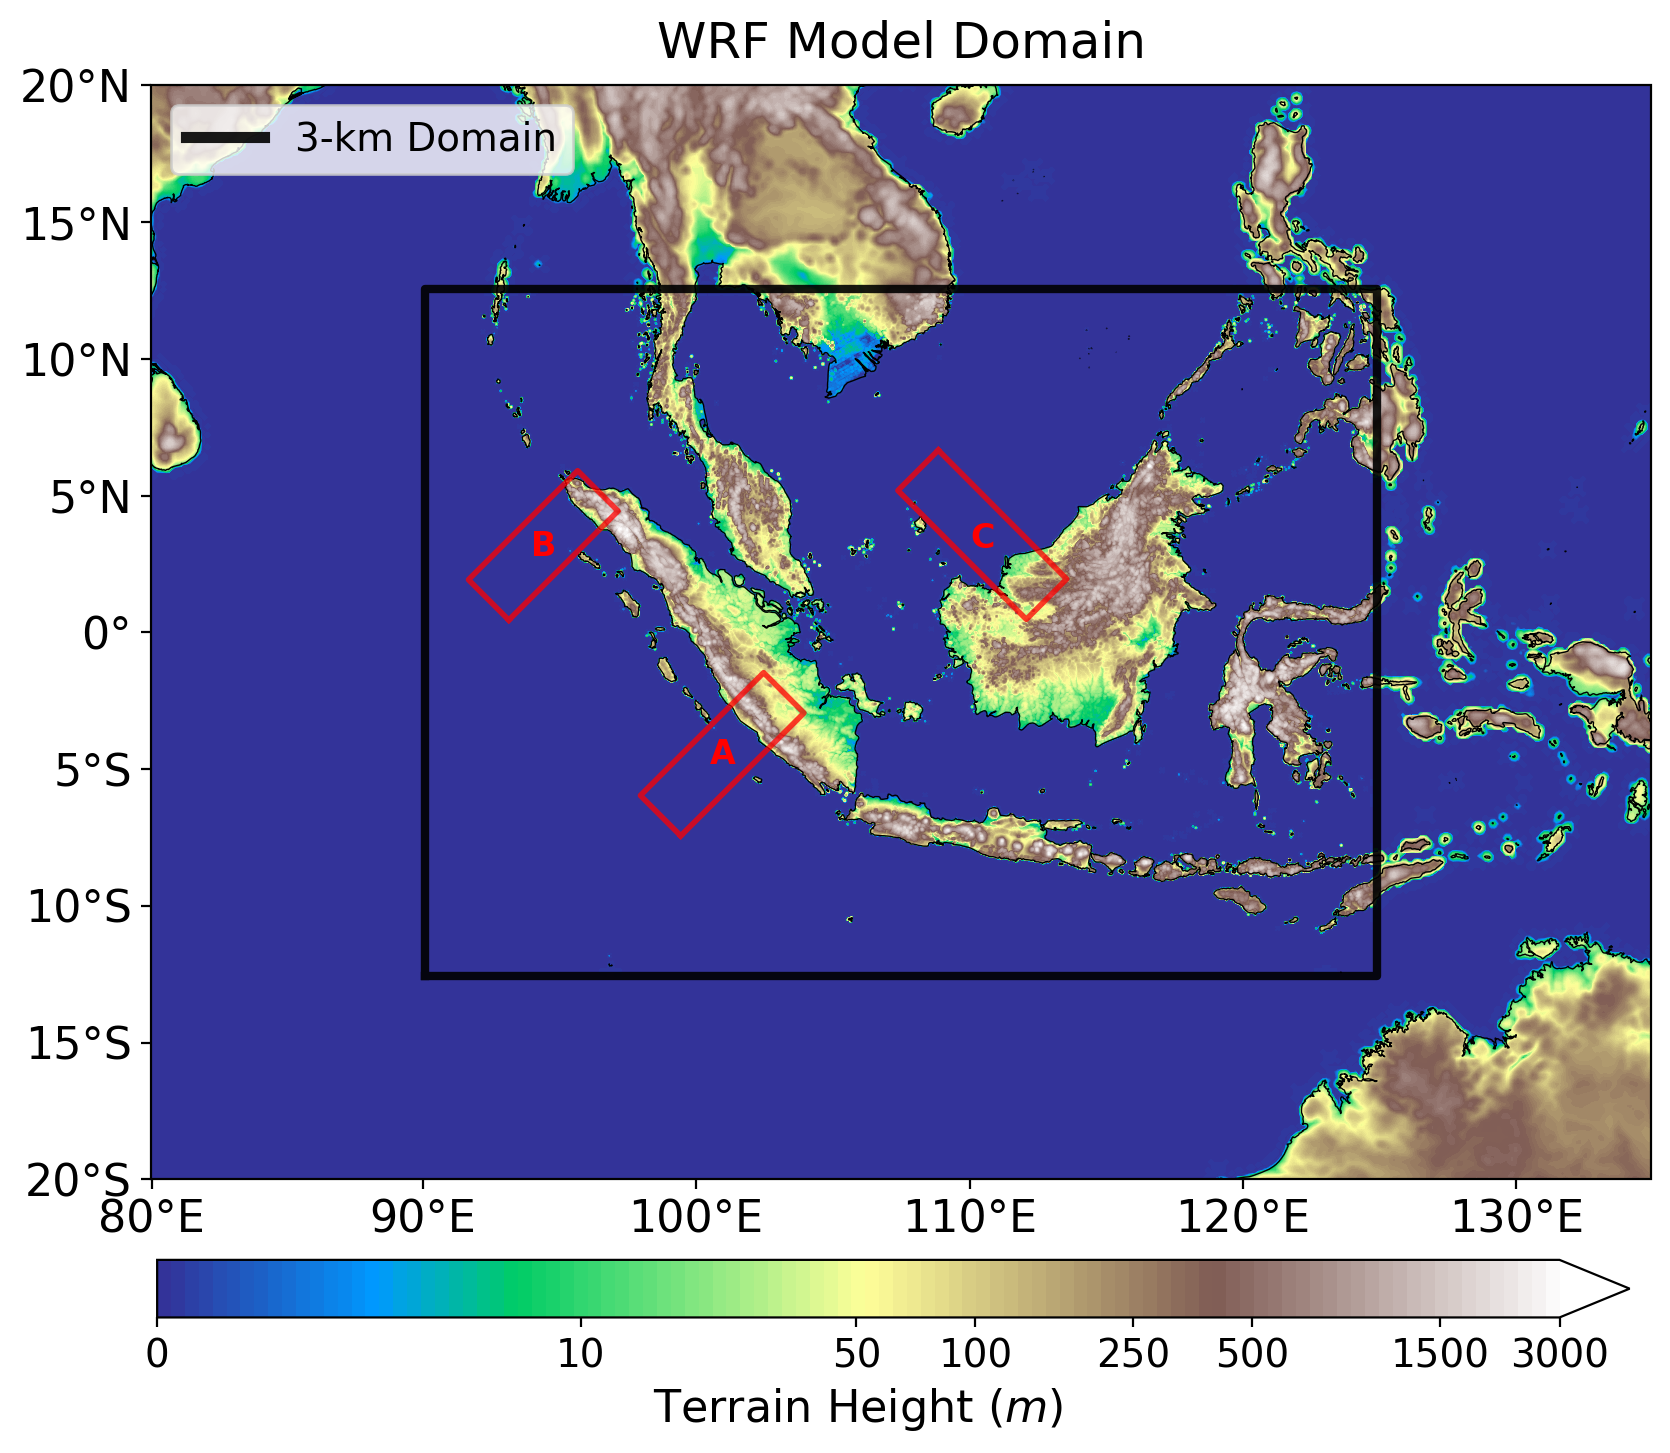

In [39]:
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[.95,.05], width_ratios=[.02,.95,.03], hspace=0.14, wspace=0)

fs=18

d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
d01_coords = dict(
    south_north=('south_north',ds_d01.XLAT[0,:,0].values),
    west_east=('west_east',ds_d01.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x_d02 = da_d02_TOPO.assign_coords(d02_coords)
da_d01_TOPO = ds_d01['HGT'].sel(Time=slice(1)).compute().squeeze()
x_d01 = da_d01_TOPO.assign_coords(d01_coords)

x_ticks = np.array([80.1,90,100,110,120,130])
x_tick_labels = [u'80\N{DEGREE SIGN}E',u'90\N{DEGREE SIGN}E', u'100\N{DEGREE SIGN}E',
                 u'110\N{DEGREE SIGN}E',u'120\N{DEGREE SIGN}E', u'130\N{DEGREE SIGN}E']
y_ticks = np.array([-20,-15,-10,-5,0,5,10,15,20])
y_tick_labels = [u'20\N{DEGREE SIGN}S',u'15\N{DEGREE SIGN}S',u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',u'0\N{DEGREE SIGN}',
                 u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N',u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,:], projection=ccrs.PlateCarree(central_longitude=0))
cf1 = x_d01.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	# levels = np.append(0,np.logspace(0,3.6,50)),
	# levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),50))),0).astype(np.int64),
	levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),100))),1),
	extend='max',
	vmin=0,
	add_colorbar=False
)

cf2 = x_d02.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	# levels = np.append(0,np.logspace(0,3.6,50)),
	# levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),50))),0).astype(np.int64),
	levels=np.round(np.concatenate(([-1],[0],np.logspace(0,np.log10(3000),100))),1),
	extend='max',
	vmin=0,
	add_colorbar=False
)

## Plot the coast lines
ax1.coastlines(linewidth=.5, color='k', resolution='10m')  # cartopy function

## Plot d02 domain box
line_lats = np.array([x_d02.south_north[0],x_d02.south_north[-1],x_d02.south_north[-1],x_d02.south_north[0],x_d02.south_north[0]])
line_lons = np.array([x_d02.west_east[0],x_d02.west_east[0],x_d02.west_east[-1],x_d02.west_east[-1],x_d02.west_east[0]])
plt.plot(line_lons, line_lats,'k', linewidth=3, alpha=.9)

# plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3)
plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs-6,alpha=.75,ax=ax1,color='r')

## Add colorbar
ax2 = fig.add_subplot(gs[1,1])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', extend='max', ticks=np.array([-1,10,50,100,250,500,1500,3000]))
cbar.set_label('Terrain Height ($m$)', fontsize=fs-2)
cbar.set_ticklabels([0,10,50,100,250,500,1500,3000],fontsize=fs-4)
cbar.minorticks_off()


ax1.set_xlabel('',fontsize=fs-2)
ax1.set_ylabel('',fontsize=fs-2)
ax1.set_title('WRF Model Domain',fontsize=fs, y=1.01)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels,fontsize=fs-2)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels,fontsize=fs-2)
legend_lines = [plt.Line2D([0], [0], color='k', alpha=0.9, linewidth=4)]
ax1.legend(legend_lines, ['3-km Domain'], fontsize=fs-4, loc='upper left', framealpha=.8)

# fig.savefig('/home/hragnajarian/PhD/plots/Domain_cross.png', transparent=True)

### Figures

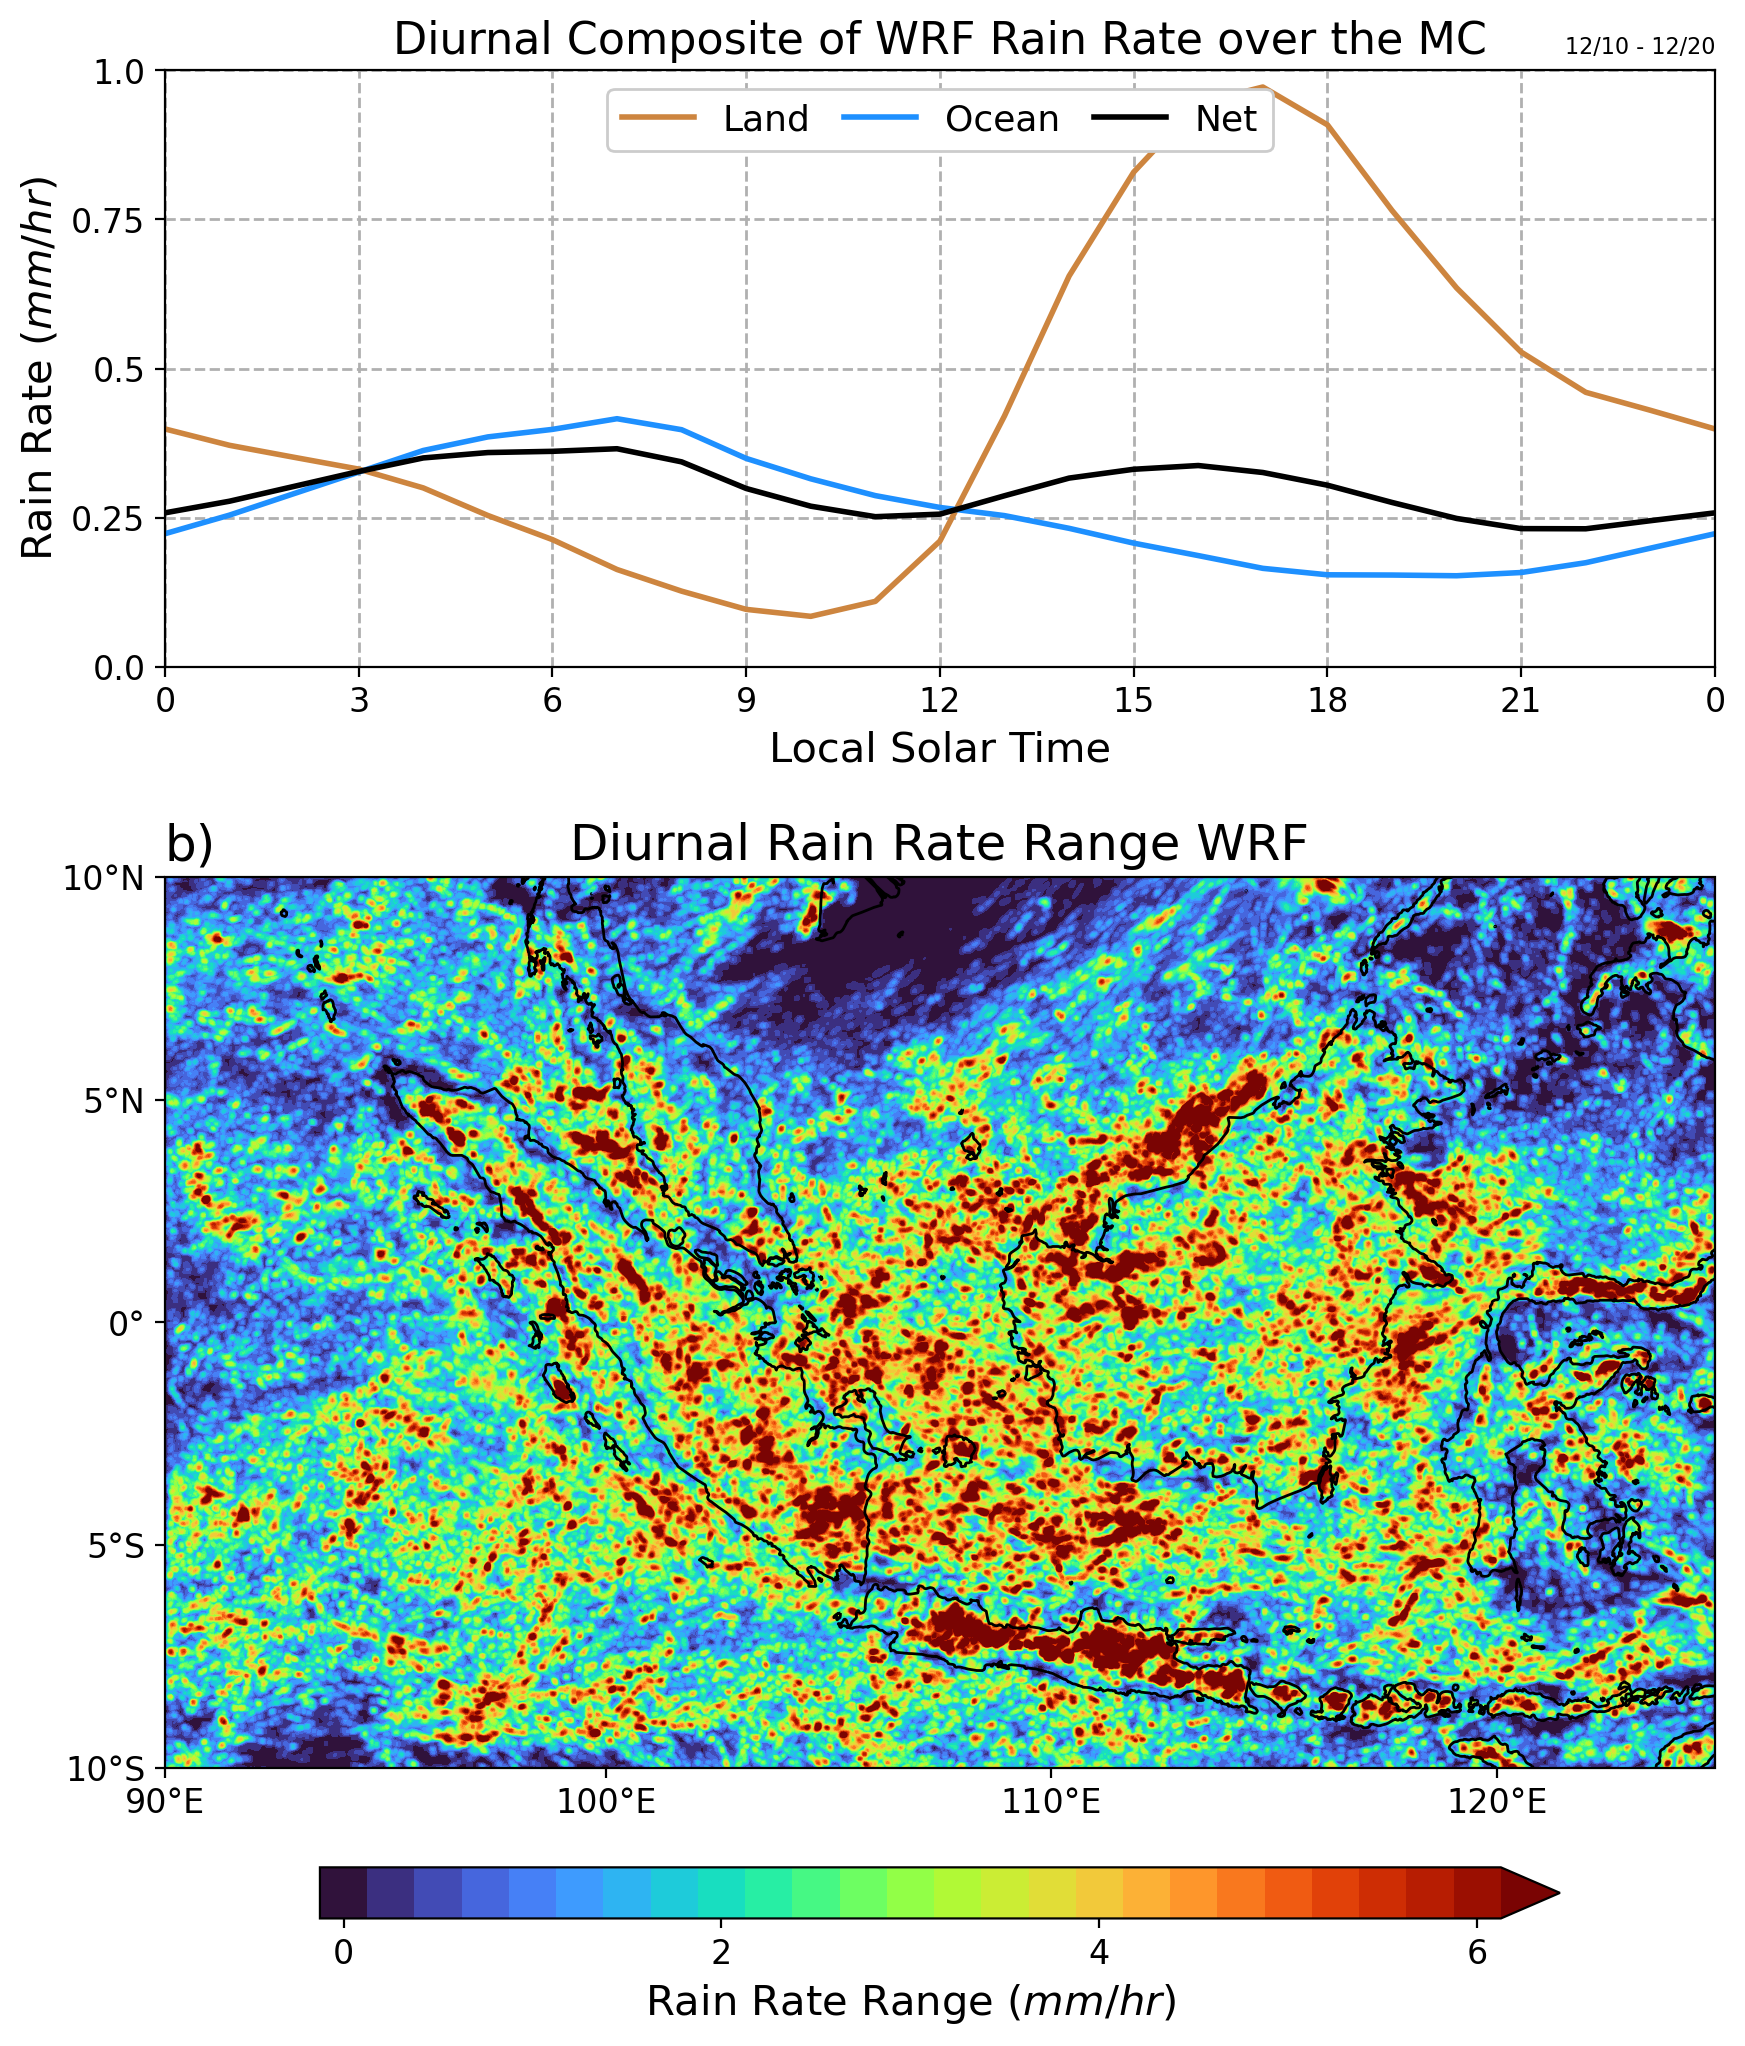

In [97]:
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(nrows=5, ncols=3, hspace=0, wspace=0, height_ratios=[.35,.075,.62,.01,.03], width_ratios=[.1,.8,.1])

ax1 = fig.add_subplot(gs[0,:])

fs = 18

# RR-land
l1 = hourly_RR_di_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='Land'
)
l2 = hourly_RR_di_cntl_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='Ocean'
)
l3 = hourly_RR_di_cntl.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Net'
)

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.arange(0,3,.25))
title = 'Diurnal Composite of WRF Rain Rate over the MC'
ax1.set_title(title, fontsize=fs-2)
# ax1.set_title('11/23 - 12/03', loc='right', fontsize=fs-10)
# ax1.set_title('12/01 - 12/10', loc='right', fontsize=fs-10)
ax1.set_title('12/10 - 12/20', loc='right', fontsize=fs-10)
# ax1.set_title('12/15 - 12/25', loc='right', fontsize=fs-10)
# ax1.set_title('12/20 - 12/30', loc='right', fontsize=fs-10)
ax1.set_xlabel('Local Solar Time', fontsize=fs-3)
ax1.set_ylabel('Rain Rate ($mm/hr$)', fontsize=fs-3)
ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.arange(0,3,.25), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=3, fontsize=fs-5, loc='upper center', framealpha=1, columnspacing=.92)
ax1.set_xlim([0,24])
ax1.set_ylim([0,1])


ax2 = fig.add_subplot(gs[2,:], projection=ccrs.PlateCarree(central_longitude=0))

levels = [0, 6]
dl = .25
lon_bound_temp = [90,125]
lat_bound_temp = [-10,10]

# No significance shading
cf = range_RR_di_cntl.plot.contourf(
    ax=ax2,
    add_colorbar=False,
    cmap='turbo',
    levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
    vmin=levels[0], vmax=levels[1],
    x='west_east',
    y='south_north',
    extend='max',
    xlim=[lon_bound_temp[0], lon_bound_temp[1]],
    ylim=[lat_bound_temp[0], lat_bound_temp[1]],
)


# plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3,ax=ax2)
# plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs,alpha=.75,ax=ax2)

# Set parameters and labels
x_ticks = [90.1,100,110,120]
x_tick_labels = [u'90\N{DEGREE SIGN}E',
                 u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
                 u'120\N{DEGREE SIGN}E']
y_ticks = [-10,-5,0,5,10]
y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
		 		u'0\N{DEGREE SIGN}',
				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# Plot the coast lines
ax2.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

ax2.set_title('Diurnal Rain Rate Range WRF', fontsize=fs, loc='center')
ax2.set_title('b)', loc='left', fontsize=fs)
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels, fontsize=fs-6)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels(y_tick_labels, fontsize=fs-6)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xlim([90.1,124.9])

ax3 = fig.add_subplot(gs[4,1])
# cbar = plt.colorbar(cf, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(-10,12,2))
cbar = plt.colorbar(cf, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,2))
cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,2), fontsize=fs-6)
cbar.minorticks_off()
cbar.set_label('Rain Rate Range ($mm/hr$)', fontsize=fs-3)

(0.1, 4.0)

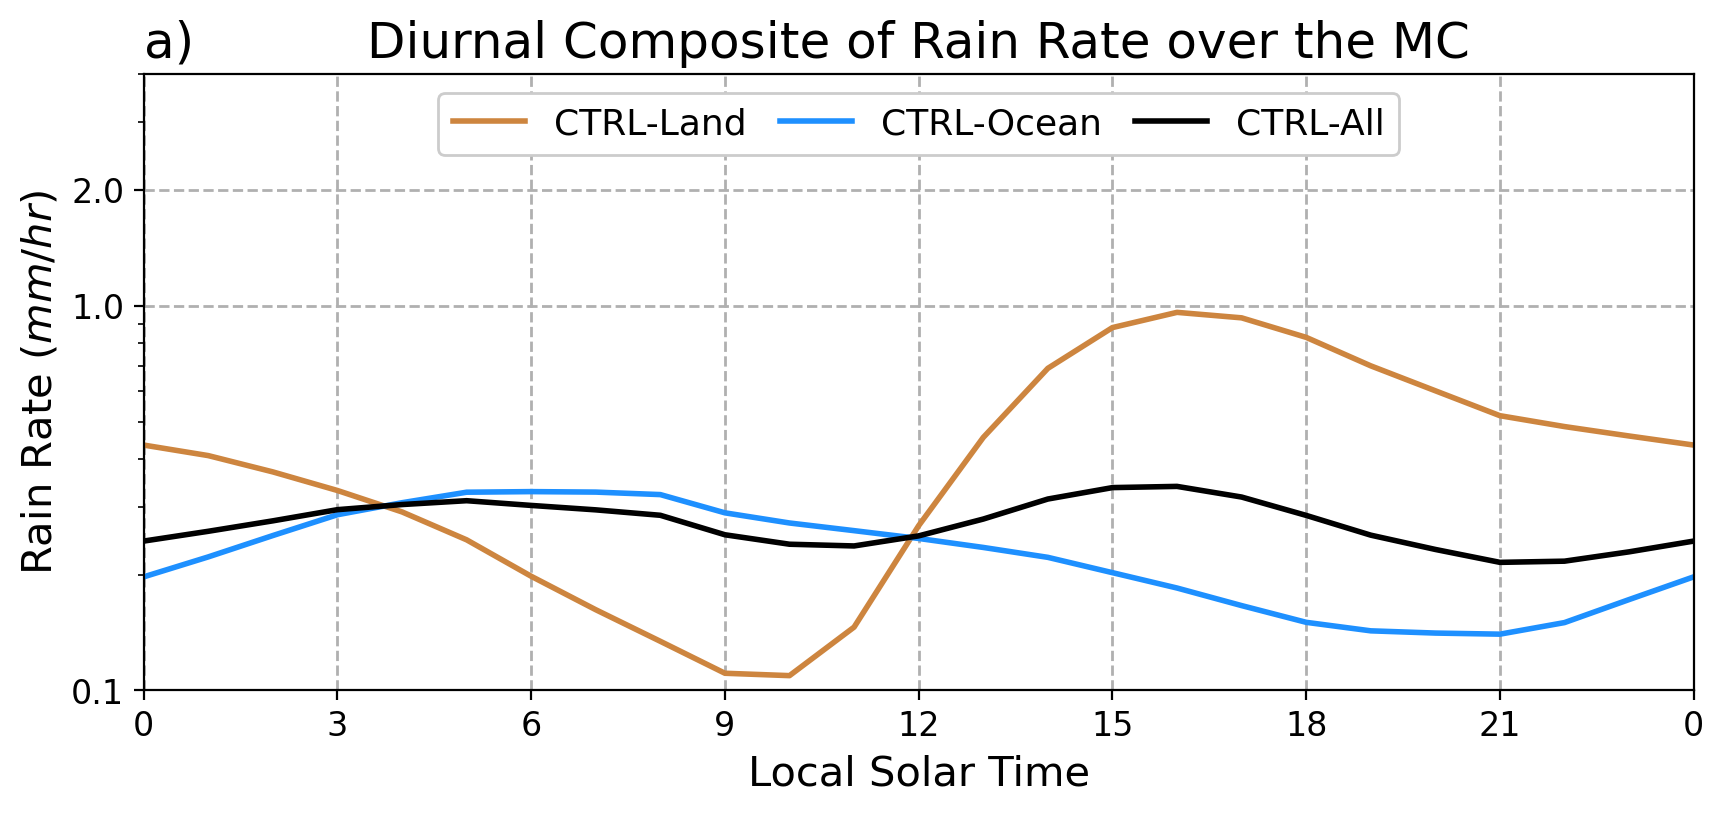

In [90]:
# fig = plt.figure(figsize=(10,12))
# gs = gridspec.GridSpec(nrows=5, ncols=3, hspace=0, wspace=0, height_ratios=[.35,.075,.62,.01,.03], width_ratios=[.1,.8,.1])

fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0,0])

fs = 18

# RR-land
l1 = hourly_RR_di_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='CTRL-Land'
)
# l2 = RR_sunrise_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='NCRF-Land'
# )
l3 = hourly_RR_di_cntl_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='CTRL-Ocean'
)
# l4 = RR_sunrise_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='NCRF-Ocean'
# )
l5 = hourly_RR_di_cntl.plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='CTRL-All'
)
# l6 = RR_sunrise_net.plot.line(
#     ax=ax1,
#     color='k',
#     linewidth=2,
#     linestyle = '--',
# 	label='NCRF-All'
# )

# # Control
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_cntl_net[0,:],sig_bars_cntl_net[0,0]), np.append(sig_bars_cntl_net[1,:],sig_bars_cntl_net[1,0]), alpha=.25, color='k')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_cntl_land[0,:],sig_bars_cntl_land[0,0]), np.append(sig_bars_cntl_land[1,:],sig_bars_cntl_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_cntl_ocean[0,:],sig_bars_cntl_ocean[0,0]), np.append(sig_bars_cntl_ocean[1,:],sig_bars_cntl_ocean[1,0]), alpha=.25, color='dodgerblue')
# # NCRF
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_sunrise_net[0,:],sig_bars_sunrise_net[0,0]), np.append(sig_bars_sunrise_net[1,:],sig_bars_sunrise_net[1,0]), alpha=.25, color='k')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_sunrise_land[0,:],sig_bars_sunrise_land[0,0]), np.append(sig_bars_sunrise_land[1,:],sig_bars_sunrise_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_sunrise_ocean[0,:],sig_bars_sunrise_ocean[0,0]), np.append(sig_bars_sunrise_ocean[1,:],sig_bars_sunrise_ocean[1,0]), alpha=.25, color='dodgerblue')

ax1.set_yscale('log')
ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.array([.1,1,2]))
title = f'Diurnal Composite of Rain Rate over the MC'
ax1.set_title(title, fontsize=fs)
ax1.set_title('a)', loc='left', fontsize=fs)
ax1.set_xlabel('Local Solar Time', fontsize=fs-3)
ax1.set_ylabel('Rain Rate ($mm/hr$)', fontsize=fs-3)
ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.array([.1,1,2]), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=3, fontsize=fs-5, loc='upper center', framealpha=1, columnspacing=.92)
ax1.set_xlim([0,24])
ax1.set_ylim([.1,4])

#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

# ax2 = fig.add_subplot(gs[2,:], projection=ccrs.PlateCarree(central_longitude=0))

# levels = [-10, 10]
# dl = .5

# # # Multiply by the significance
# # cf = (amplitude_RR_di_diff*amplitude_RR_di_diff.significance).plot.contourf(
# #     ax=ax2,
# #     add_colorbar=False,
# #     cmap='RdBu_r',
# #     # levels=np.arange(-10,11,1),
# #     levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
# #     vmin=levels[0], vmax=levels[1],
# #     x='west_east',
# #     y='south_north',
# #     extend='both',
# #     xlim=[lon_bound[0], lon_bound[1]],
# #     ylim=[lat_bound[0], lat_bound[1]],
# # )

# # # Plot grey shading over areas where it's not significant
# # cf2 =  (.6*(~amplitude_RR_di_diff.significance)).plot.contourf(
# #     ax=ax2,
# #     add_colorbar=False,
# #     cmap='Greys',
# #     levels=np.arange(0,1.5,.5),
# #     vmin=0, vmax=1,
# #     x='west_east',
# #     y='south_north',
# #     extend='neither',
# #     alpha=.125,
# #     xlim=[lon_bound[0], lon_bound[1]],
# #     ylim=[lat_bound[0], lat_bound[1]],
# # )

# # No sig
# cf = range_RR_di_diff.plot.contourf(
#     ax=ax2,
#     add_colorbar=False,
#     cmap='RdBu_r',
#     # levels=np.arange(-10,11,1),
#     levels=np.arange(levels[0]-(dl/2),levels[1]+dl+(dl/2),dl),
#     vmin=levels[0], vmax=levels[1],
#     x='west_east',
#     y='south_north',
#     extend='both',
#     xlim=[lon_bound[0], lon_bound[1]],
#     ylim=[lat_bound[0], lat_bound[1]],
# )


# # plot_cross_lines(all_line_coords1,all_line_coords2,all_line_coords3,ax=ax2)
# plot_cross_box(all_line_coords1,all_line_coords2,all_line_coords3,fs,alpha=.75,ax=ax2,color='k')

# # Set parameters and labels
# x_ticks = [90.1,100,110,120]
# x_tick_labels = [u'90\N{DEGREE SIGN}E',
#                  u'100\N{DEGREE SIGN}E', u'110\N{DEGREE SIGN}E',
#                  u'120\N{DEGREE SIGN}E']
# y_ticks = [-10,-5,0,5,10]
# y_tick_labels = [u'10\N{DEGREE SIGN}S',u'5\N{DEGREE SIGN}S',
# 		 		u'0\N{DEGREE SIGN}',
# 				u'5\N{DEGREE SIGN}N',u'10\N{DEGREE SIGN}N']

# # Plot the coast lines
# ax2.coastlines(linewidth=1, color='k', resolution='10m')  # cartopy function

# ax2.set_title('Diurnal Rain Rate Range Difference (NCRF - CTRL)', fontsize=fs, loc='center')
# ax2.set_title('b)', loc='left', fontsize=fs)
# ax2.set_xticks(x_ticks)
# ax2.set_xticklabels(x_tick_labels, fontsize=fs-6)
# ax2.set_yticks(y_ticks)
# ax2.set_yticklabels(y_tick_labels, fontsize=fs-6)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.set_xlim([90.1,124.9])

# ax3 = fig.add_subplot(gs[4,1])
# # cbar = plt.colorbar(cf, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(-10,12,2))
# cbar = plt.colorbar(cf, cax=ax3, orientation='horizontal', extend='both', ticks=np.arange(levels[0],levels[1]+1,2))
# cbar.set_ticklabels(np.arange(levels[0],levels[1]+1,2), fontsize=fs-6)
# cbar.minorticks_off()
# cbar.set_label('$\Delta$ Rain Rate Range ($mm/hr$)', fontsize=fs-3)

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandRR.png', transparent=True)

(0.0, 0.15)

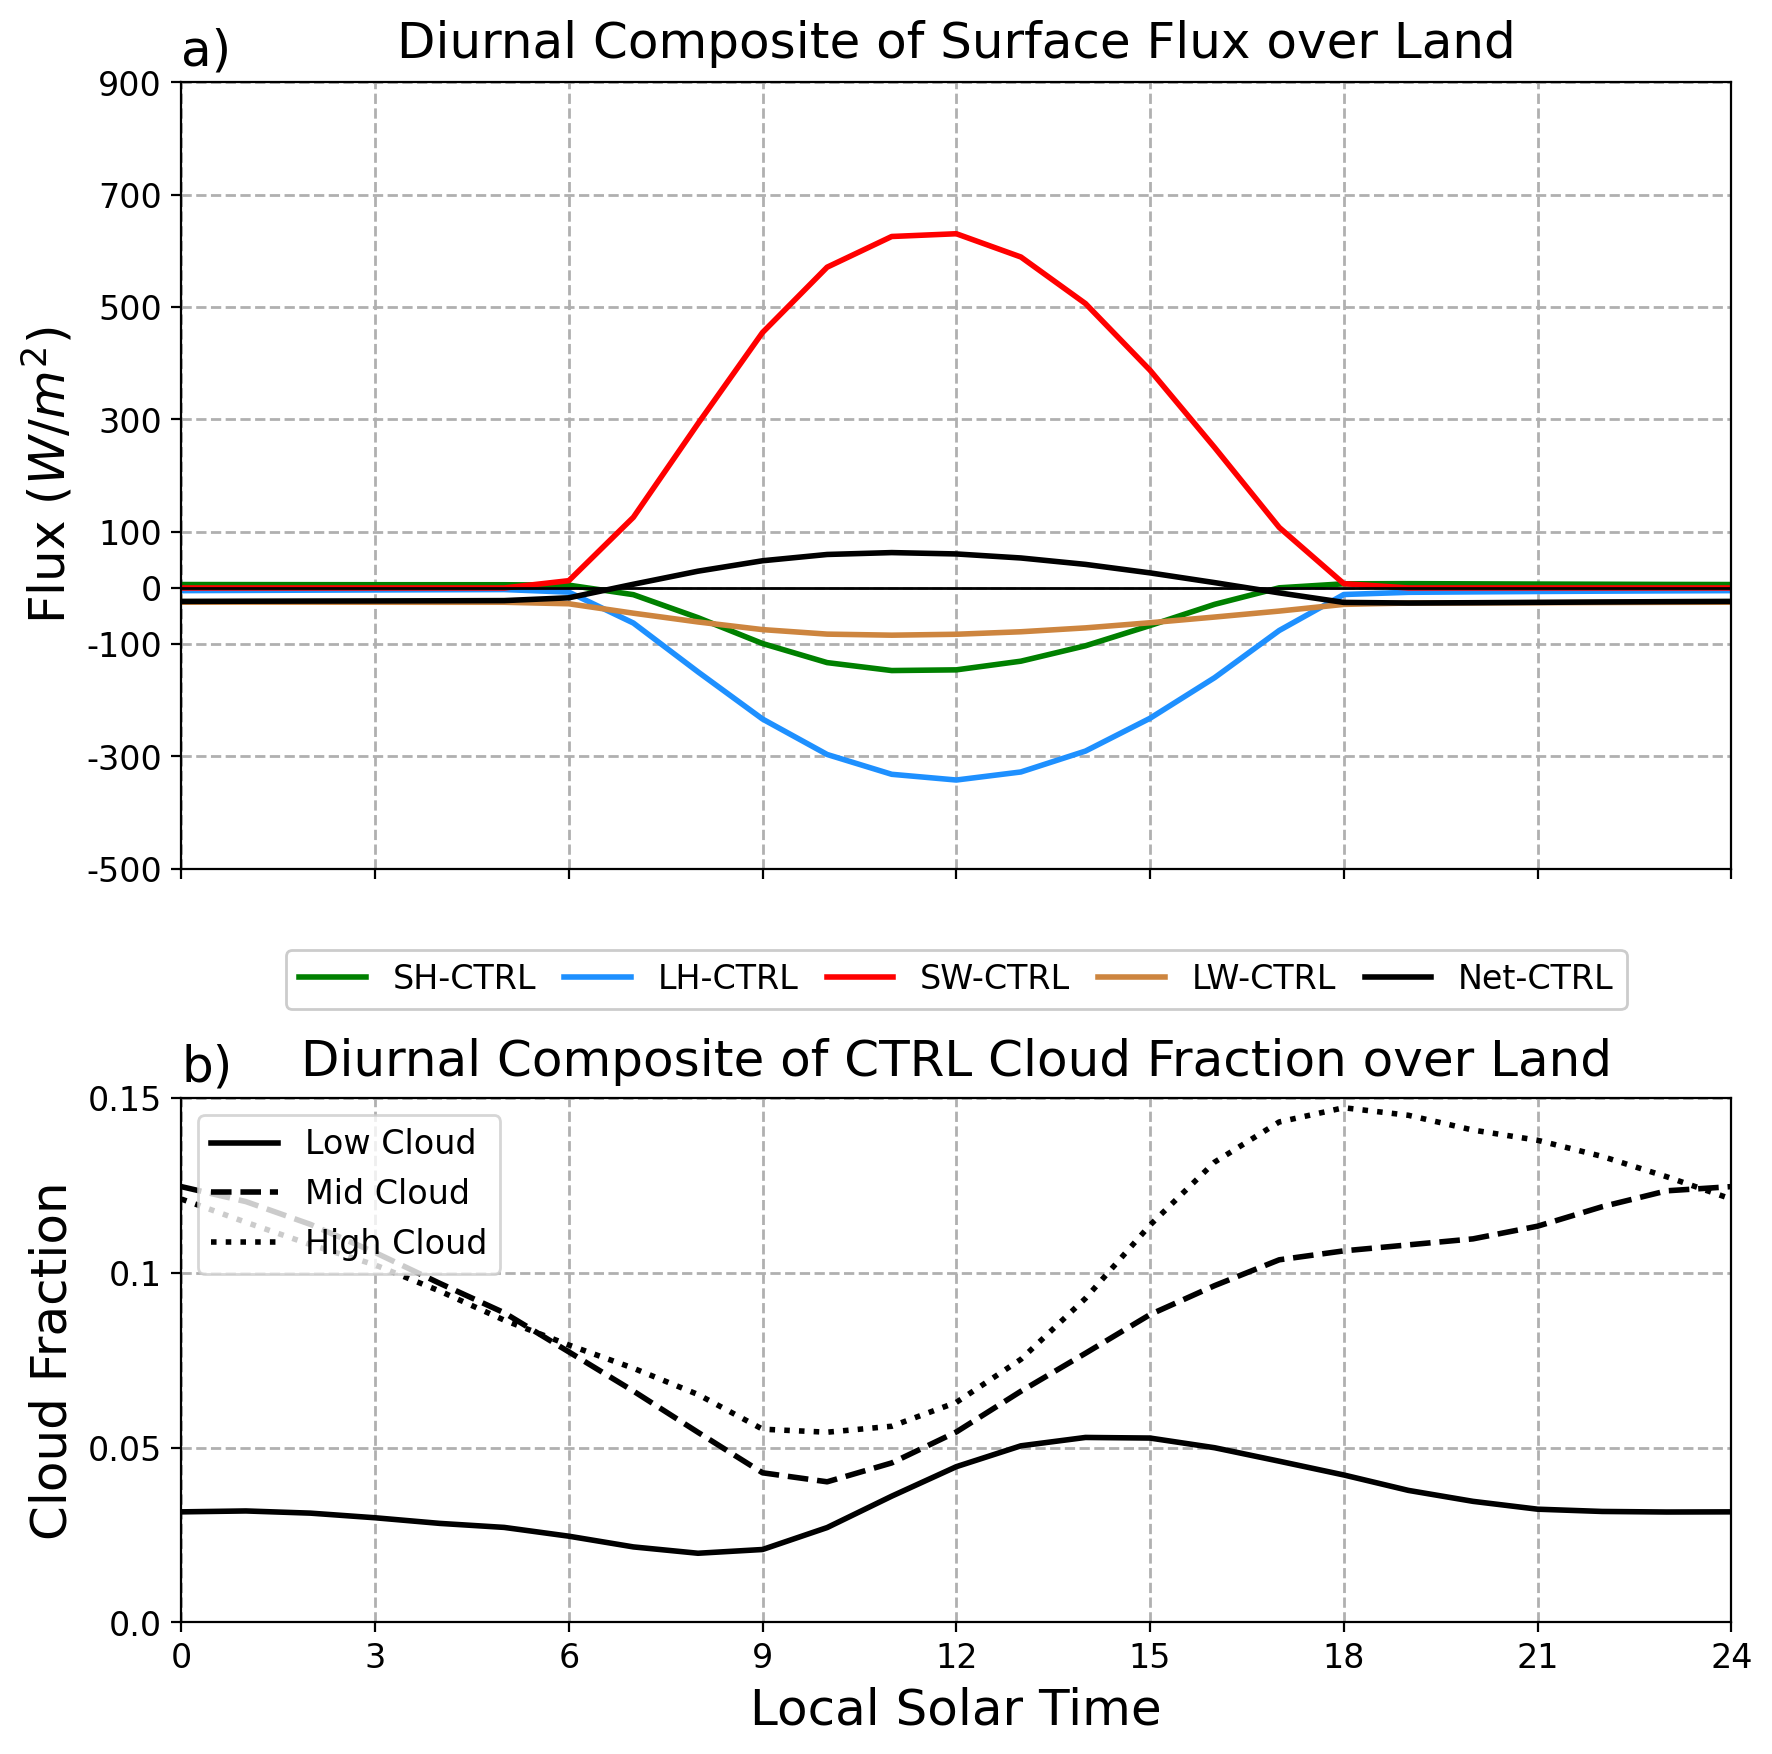

In [70]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.35, height_ratios=[.6,.4])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

fs = 18

l1 = (-hourly_HFX_di_cntl_land).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '-',
	label='SH-CTRL'
)
l3 = (-hourly_LH_di_cntl_land).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='LH-CTRL'
)
l5 = hourly_SWSFC_di_cntl_land.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='SW-CTRL'
)
l7 = hourly_LWSFC_di_cntl_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LW-CTRL'
)
l9 = (-(hourly_LH_di_cntl_land+hourly_HFX_di_cntl_land)+hourly_SWSFC_di_cntl_land+hourly_LWSFC_di_cntl_land).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Net-CTRL'
)



# l2 = (-HFX_sunrise_land).plot.line(
#     ax=ax1,
#     color='green',
#     linewidth=2,
#     linestyle = '--',
# 	label='SH-NCRF'
# )
# l4 = (-LH_sunrise_land).plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='LH-NCRF'
# )
# l6 = SWSFC_sunrise_land.plot.line(
#     ax=ax1,
#     color='r',
#     linewidth=2,
#     linestyle = '--',
# 	label='SW-NCRF'
# )
# l8 = LWSFC_sunrise_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='LW-NCRF'
# )
# l10 = (-(LH_sunrise_land+HFX_sunrise_land)+SWSFC_sunrise_land+LWSFC_sunrise_land).plot.line(
#     ax=ax1,
#     color='k',
#     linewidth=2,
#     linestyle = '--',
# 	label='Net-NCRF'
# )


# CLDFRA
l9 = hourly_LowCLDFRA_di_cntl_land.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Low Cloud'
)
# CLDFRA
l11 = hourly_MidCLDFRA_di_cntl_land.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='Mid Cloud'
)
# CLDFRA
l13 = hourly_HighCLDFRA_di_cntl_land.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = ':',
	label='High Cloud'
)

# # Control
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_HFX_cntl_land[0,:],sig_bars_HFX_cntl_land[0,0]), np.append(sig_bars_HFX_cntl_land[1,:],sig_bars_HFX_cntl_land[1,0]), alpha=.25, color='green')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LH_cntl_land[0,:],sig_bars_LH_cntl_land[0,0]), np.append(sig_bars_LH_cntl_land[1,:],sig_bars_LH_cntl_land[1,0]), alpha=.25, color='dodgerblue')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_SW_cntl_land[0,:],sig_bars_SW_cntl_land[0,0]), np.append(sig_bars_SW_cntl_land[1,:],sig_bars_SW_cntl_land[1,0]), alpha=.25, color='r')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LW_cntl_land[0,:],sig_bars_LW_cntl_land[0,0]), np.append(sig_bars_LW_cntl_land[1,:],sig_bars_LW_cntl_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_Net_cntl_land[0,:],sig_bars_Net_cntl_land[0,0]), np.append(sig_bars_Net_cntl_land[1,:],sig_bars_Net_cntl_land[1,0]), alpha=.25, color='k')

# # NCRF
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_HFX_sunrise_land[0,:],sig_bars_HFX_sunrise_land[0,0]), np.append(sig_bars_HFX_sunrise_land[1,:],sig_bars_HFX_sunrise_land[1,0]), alpha=.25, color='green')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LH_sunrise_land[0,:],sig_bars_LH_sunrise_land[0,0]), np.append(sig_bars_LH_sunrise_land[1,:],sig_bars_LH_sunrise_land[1,0]), alpha=.25, color='dodgerblue')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_SW_sunrise_land[0,:],sig_bars_SW_sunrise_land[0,0]), np.append(sig_bars_SW_sunrise_land[1,:],sig_bars_SW_sunrise_land[1,0]), alpha=.25, color='r')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LW_sunrise_land[0,:],sig_bars_LW_sunrise_land[0,0]), np.append(sig_bars_LW_sunrise_land[1,:],sig_bars_LW_sunrise_land[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_Net_sunrise_land[0,:],sig_bars_Net_sunrise_land[0,0]), np.append(sig_bars_Net_sunrise_land[1,:],sig_bars_Net_sunrise_land[1,0]), alpha=.25, color='k')

fs = 18

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))))
ax2.set_xticks(np.arange(0,25,3))
ax2.set_yticks(np.array([0,0.05,0.1,0.15,0.2,0.25,0.3]))
title = f'Diurnal Composite of Surface Flux over Land'
ax1.set_title(title, fontsize=fs, y=1.01)
ax1.set_title('a)', loc='left', fontsize=fs)
title = f'Diurnal Composite of CTRL Cloud Fraction over Land'
ax2.set_title(title, fontsize=fs, y=1.01)
ax2.set_title('b)', loc='left', fontsize=fs)
ax1.set_xlabel('', fontsize=fs)
ax2.set_xlabel('Local Solar Time', fontsize=fs)
ax1.set_ylabel('Flux ($W/m^{2}$)', fontsize=fs)
ax2.set_ylabel('Cloud Fraction', fontsize=fs)
ax1.set_xticklabels([], fontsize=fs-6)
ax2.set_xticklabels(np.arange(0,25,3), fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))), fontsize=fs-6)
ax2.set_yticklabels(np.array([0,0.05,0.1,0.15,0.2,0.25,0.3]), fontsize=fs-6)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=5, fontsize=fs-6, loc='lower center', framealpha=1, columnspacing=.85, bbox_to_anchor=(0.5,-0.2))
ax2.legend(ncol=1, fontsize=fs-6, loc='upper left')
ax1.set_xlim([0,24])
ax2.set_xlim([0,24])
ax1.set_ylim([-500,900])
ax2.set_ylim([0,.15])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandSWSFC.png', transparent=True)

(0.0, 0.15)

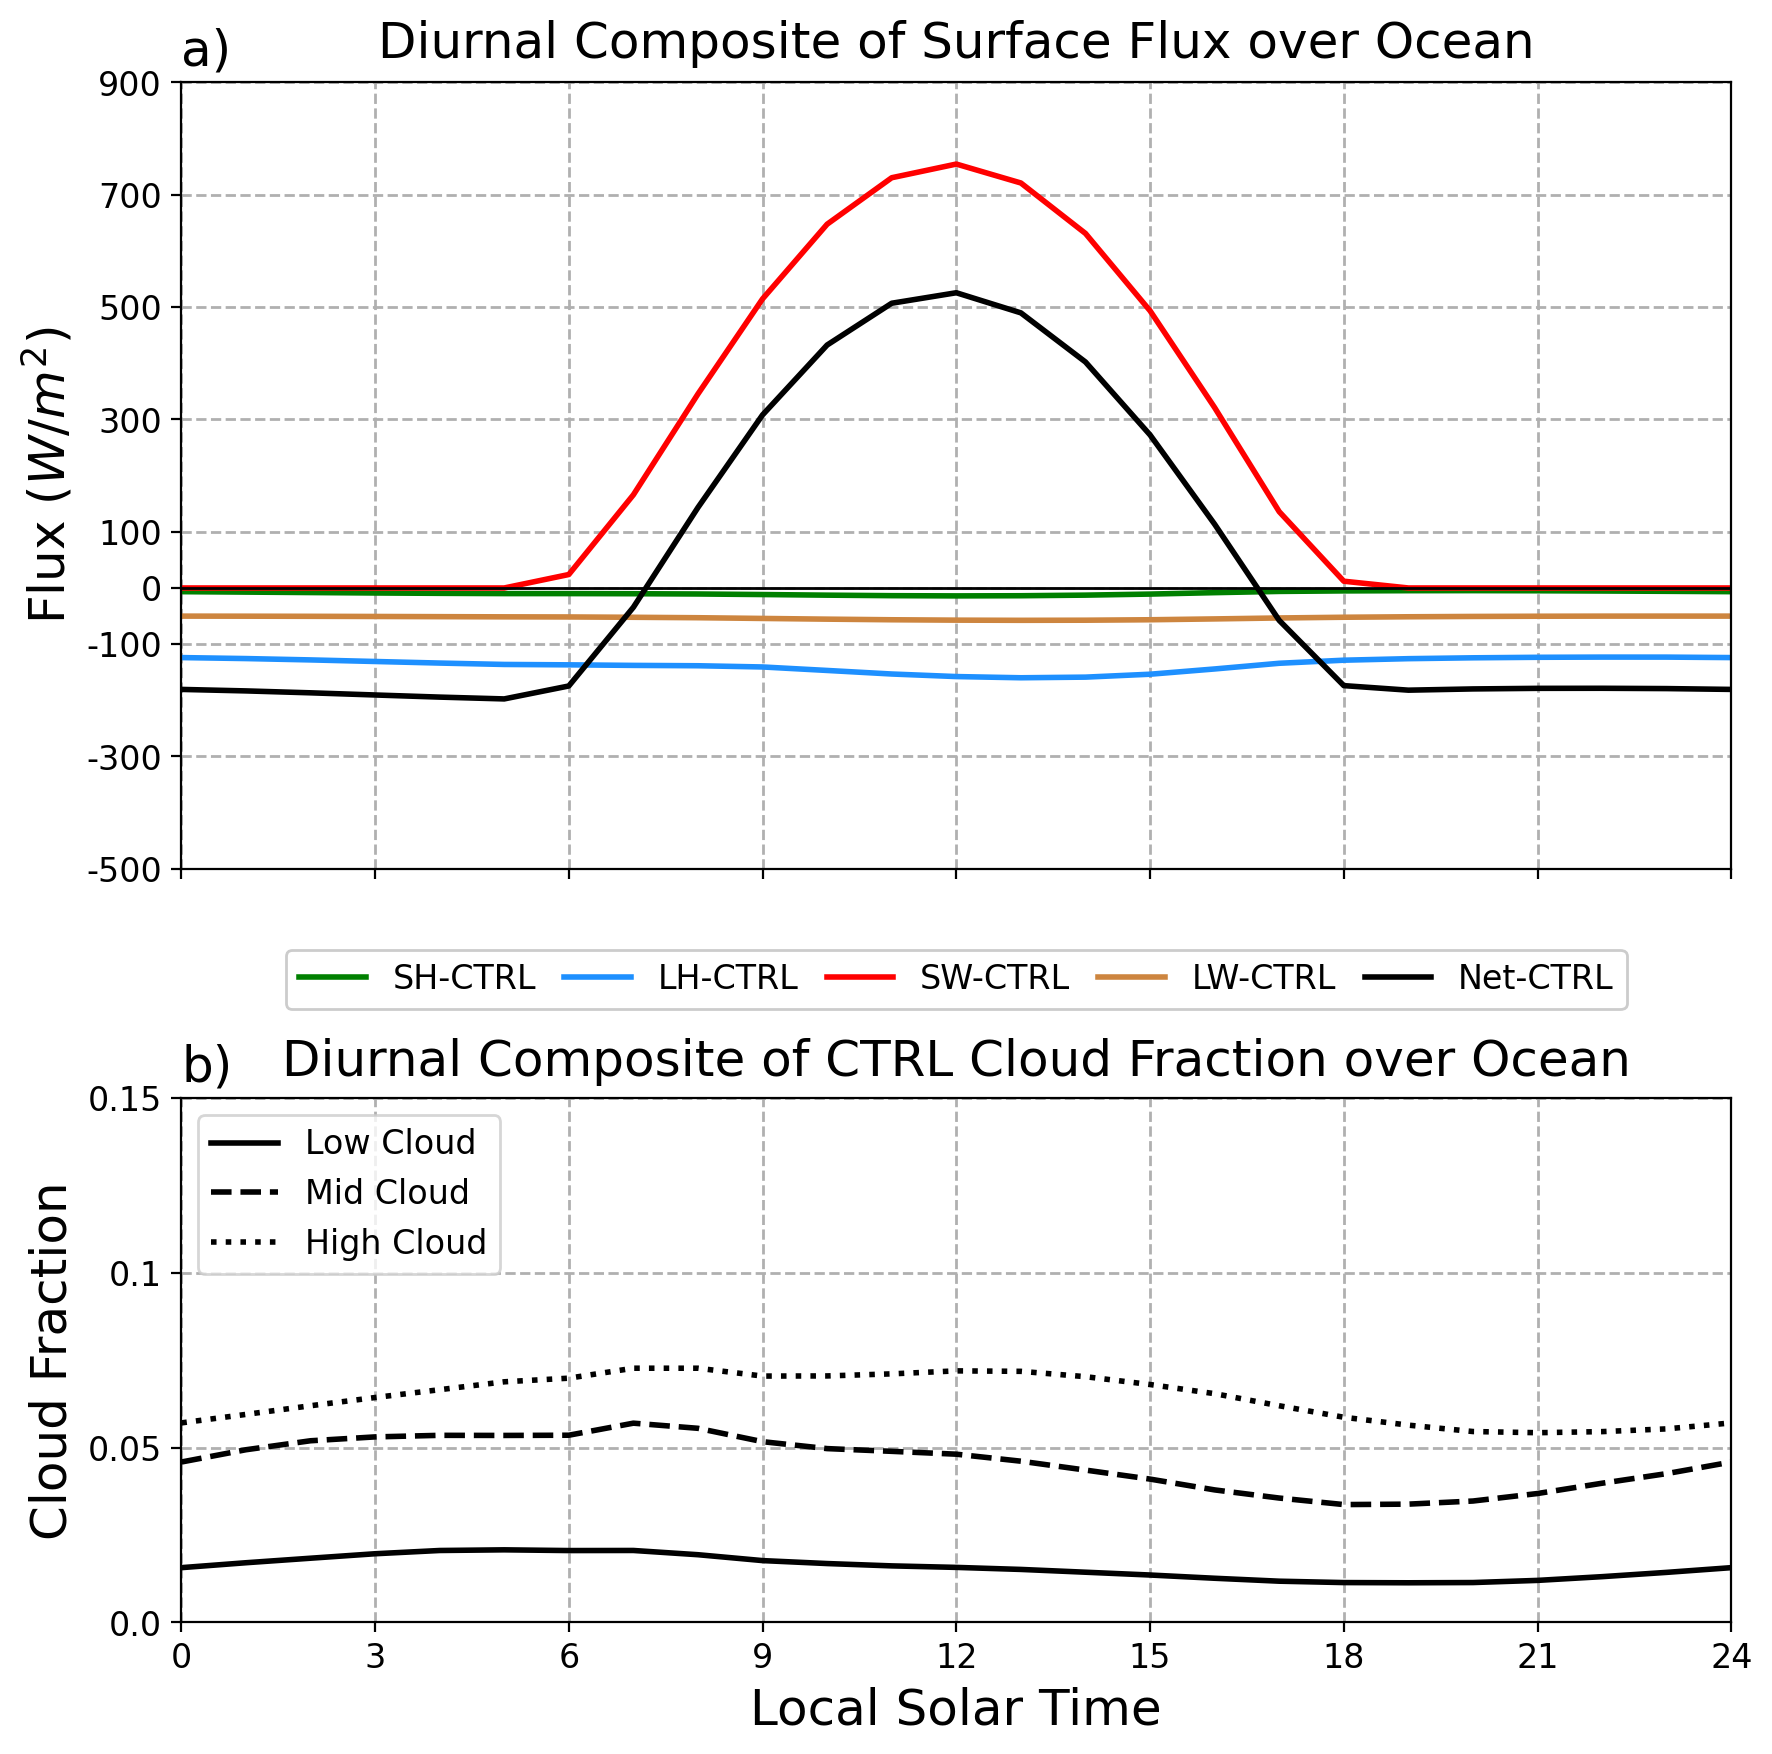

In [72]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(nrows=2, ncols=1, hspace=0.35, height_ratios=[.6,.4])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

fs = 18

l1 = (-hourly_HFX_di_cntl_ocean).plot.line(
    ax=ax1,
    color='green',
    linewidth=2,
    linestyle = '-',
	label='SH-CTRL'
)
l3 = (-hourly_LH_di_cntl_ocean).plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='LH-CTRL'
)
l5 = hourly_SWSFC_di_cntl_ocean.plot.line(
    ax=ax1,
    color='r',
    linewidth=2,
    linestyle = '-',
	label='SW-CTRL'
)
l7 = hourly_LWSFC_di_cntl_ocean.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='LW-CTRL'
)
l9 = (-(hourly_LH_di_cntl_ocean+hourly_HFX_di_cntl_ocean)+hourly_SWSFC_di_cntl_ocean+hourly_LWSFC_di_cntl_ocean).plot.line(
    ax=ax1,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Net-CTRL'
)



# l2 = (-HFX_sunrise_ocean).plot.line(
#     ax=ax1,
#     color='green',
#     linewidth=2,
#     linestyle = '--',
# 	label='SH-NCRF'
# )
# l4 = (-LH_sunrise_ocean).plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='LH-NCRF'
# )
# l6 = SWSFC_sunrise_ocean.plot.line(
#     ax=ax1,
#     color='r',
#     linewidth=2,
#     linestyle = '--',
# 	label='SW-NCRF'
# )
# l8 = LWSFC_sunrise_ocean.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='LW-NCRF'
# )
# l10 = (-(LH_sunrise_ocean+HFX_sunrise_ocean)+SWSFC_sunrise_ocean+LWSFC_sunrise_ocean).plot.line(
#     ax=ax1,
#     color='k',
#     linewidth=2,
#     linestyle = '--',
# 	label='Net-NCRF'
# )


# CLDFRA
l9 = hourly_LowCLDFRA_di_cntl_ocean.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = '-',
	label='Low Cloud'
)
# CLDFRA
l11 = hourly_MidCLDFRA_di_cntl_ocean.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = '--',
	label='Mid Cloud'
)
# CLDFRA
l13 = hourly_HighCLDFRA_di_cntl_ocean.plot.line(
    ax=ax2,
    color='k',
    linewidth=2,
    linestyle = ':',
	label='High Cloud'
)

# # Control
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_HFX_cntl_ocean[0,:],sig_bars_HFX_cntl_ocean[0,0]), np.append(sig_bars_HFX_cntl_ocean[1,:],sig_bars_HFX_cntl_ocean[1,0]), alpha=.25, color='green')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LH_cntl_ocean[0,:],sig_bars_LH_cntl_ocean[0,0]), np.append(sig_bars_LH_cntl_ocean[1,:],sig_bars_LH_cntl_ocean[1,0]), alpha=.25, color='dodgerblue')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_SW_cntl_ocean[0,:],sig_bars_SW_cntl_ocean[0,0]), np.append(sig_bars_SW_cntl_ocean[1,:],sig_bars_SW_cntl_ocean[1,0]), alpha=.25, color='r')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LW_cntl_ocean[0,:],sig_bars_LW_cntl_ocean[0,0]), np.append(sig_bars_LW_cntl_ocean[1,:],sig_bars_LW_cntl_ocean[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_Net_cntl_ocean[0,:],sig_bars_Net_cntl_ocean[0,0]), np.append(sig_bars_Net_cntl_ocean[1,:],sig_bars_Net_cntl_ocean[1,0]), alpha=.25, color='k')

# # NCRF
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_HFX_sunrise_ocean[0,:],sig_bars_HFX_sunrise_ocean[0,0]), np.append(sig_bars_HFX_sunrise_ocean[1,:],sig_bars_HFX_sunrise_ocean[1,0]), alpha=.25, color='green')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LH_sunrise_ocean[0,:],sig_bars_LH_sunrise_ocean[0,0]), np.append(sig_bars_LH_sunrise_ocean[1,:],sig_bars_LH_sunrise_ocean[1,0]), alpha=.25, color='dodgerblue')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_SW_sunrise_ocean[0,:],sig_bars_SW_sunrise_ocean[0,0]), np.append(sig_bars_SW_sunrise_ocean[1,:],sig_bars_SW_sunrise_ocean[1,0]), alpha=.25, color='r')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_LW_sunrise_ocean[0,:],sig_bars_LW_sunrise_ocean[0,0]), np.append(sig_bars_LW_sunrise_ocean[1,:],sig_bars_LW_sunrise_ocean[1,0]), alpha=.25, color='peru')
# ax1.fill_between(np.arange(0,25,1), np.append(sig_bars_Net_sunrise_ocean[0,:],sig_bars_Net_sunrise_ocean[0,0]), np.append(sig_bars_Net_sunrise_ocean[1,:],sig_bars_Net_sunrise_ocean[1,0]), alpha=.25, color='k')

fs = 18

ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))))
ax2.set_xticks(np.arange(0,25,3))
ax2.set_yticks(np.array([0,0.05,0.1,0.15,0.2,0.25,0.3]))
title = f'Diurnal Composite of Surface Flux over Ocean'
ax1.set_title(title, fontsize=fs, y=1.01)
ax1.set_title('a)', loc='left', fontsize=fs)
title = f'Diurnal Composite of CTRL Cloud Fraction over Ocean'
ax2.set_title(title, fontsize=fs, y=1.01)
ax2.set_title('b)', loc='left', fontsize=fs)
ax1.set_xlabel('', fontsize=fs)
ax2.set_xlabel('Local Solar Time', fontsize=fs)
ax1.set_ylabel('Flux ($W/m^{2}$)', fontsize=fs)
ax2.set_ylabel('Cloud Fraction', fontsize=fs)
ax1.set_xticklabels([], fontsize=fs-6)
ax2.set_xticklabels(np.arange(0,25,3), fontsize=fs-6)
ax1.set_yticklabels(np.concatenate((np.arange(-500,0,200),[0],np.arange(100,1200,200))), fontsize=fs-6)
ax2.set_yticklabels(np.array([0,0.05,0.1,0.15,0.2,0.25,0.3]), fontsize=fs-6)
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=1)
ax1.legend(ncol=5, fontsize=fs-6, loc='lower center', framealpha=1, columnspacing=.85, bbox_to_anchor=(0.5,-0.2))
ax2.legend(ncol=1, fontsize=fs-6, loc='upper left')
ax1.set_xlim([0,24])
ax2.set_xlim([0,24])
ax1.set_ylim([-500,900])
ax2.set_ylim([0,.15])

# Save figure
# fig.savefig('/home/hragnajarian/PhD/plots/DC_HFXandSWSFC.png', transparent=True)